<a href="https://colab.research.google.com/github/SebastianSanchez5/DataAnalysis/blob/main/Sebastian_Sanchez_Copy_of_A_Introduction_to_Time_Series_and_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Time Series and Forecasting

*Based on the book [Introduction to Time Series and Forecasting](https://link.springer.com/book/10.1007/978-3-319-29854-2) by Brockwell and Davis.*



## Learning objectives

* Recognise and plot time‑indexed data
* Pull external time series data via API & libraries (stocks, FRED)
* Normalize time series data by indexing and through inflation adjustment
* Diagnose autocorrelation, seasonality, trend
* Apply rolling, expanding windows for trend extraction, and spectral tools to periodicity detection

In [1]:
#@title Setup

!pip install -U -q PyMySQL sqlalchemy yfinance fredapi

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy import text

from fredapi import Fred
import yfinance as yf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.4/118.4 kB 7.2 MB/s eta 0:00:00


In [2]:
#@title Plotting Setup

%config InlineBackend.figure_format = 'retina'

# Change the graph defaults
plt.rcParams['figure.figsize'] = (8, 3)  # Default figure size of 6x2 inches
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'lightgray'
plt.rcParams['font.size'] = 10  # Default font size of 12 points
plt.rcParams['lines.linewidth'] = 1  # Default line width of 1 points
plt.rcParams['lines.markersize'] = 3  # Default marker size of 3 points
plt.rcParams['legend.fontsize'] = 10  # Default legend font size of 10 points

## What is a Time Series?

A time series is a set of observations $x_t$, each one being recorded at a specific time $t$. In our sessions, we focus on **_discrete_** time series, where observations are recorded at fixed time intervals (e.g., once an hour, or every 30 seconds, or every 7 days).

We only consider **_regular_** time series, where we the time between observations is constant (i.e., we do not consider account deposits or withdrawals from an ATM that happen at various times; these are examples of an irregular time series).

### Typical questions in Time Series Analysis

* What is the overall trend?
* Is the current month above or below expectations?
* Do we observe any anomalies in our data?
* What should we expect for next month? Next year?

To answer such questions, we typically start by considering a few **models** of time series, and see how well such models capture the behavior of the data that we have.

For example, it is important to recognize the presence of **seasonal components** and to remove them so as not to confuse them with long-term trends. This process is known as **seasonal adjustment**.



## Examples of Time Series



### Australian red wine sales, Jan 80 - Oct 91

The file [`australian-wine-sales.txt`](https://storage.googleapis.com/datasets_nyu/australian-wine-sales.txt) contains the monthly sales of Australian red wines in for the period Jan-1980 to Oct-1991. Let's take a peak at the data file: We will use Pandas and the `pd.read_csv` function to read the text file into a dataframe.

In [3]:
url = "https://storage.googleapis.com/datasets_nyu/australian-wine-sales.txt"
df = pd.read_csv(url, sep='\t')

##### What is this code?
# The `read_csv` command can read directly from a URL, so we pass directly
# the URL of the dataset as a parameter. Also, since the file uses the
# tab character to separate the columns, we pass the `sep='\t'` option to
# the `read_csv` command, indicating that the separator is the "tab"
# (i.e. `\t` ) character.


In [4]:
df.head(10)

,Date,Sales
0,Jan-80,464
1,Feb-80,675
2,Mar-80,703
3,Apr-80,887
4,May-80,1139
5,Jun-80,1077
6,Jul-80,1318
7,Aug-80,1260
8,Sep-80,1120
9,Oct-80,963


We can plot the time series:

<Axes: xlabel='Date'>

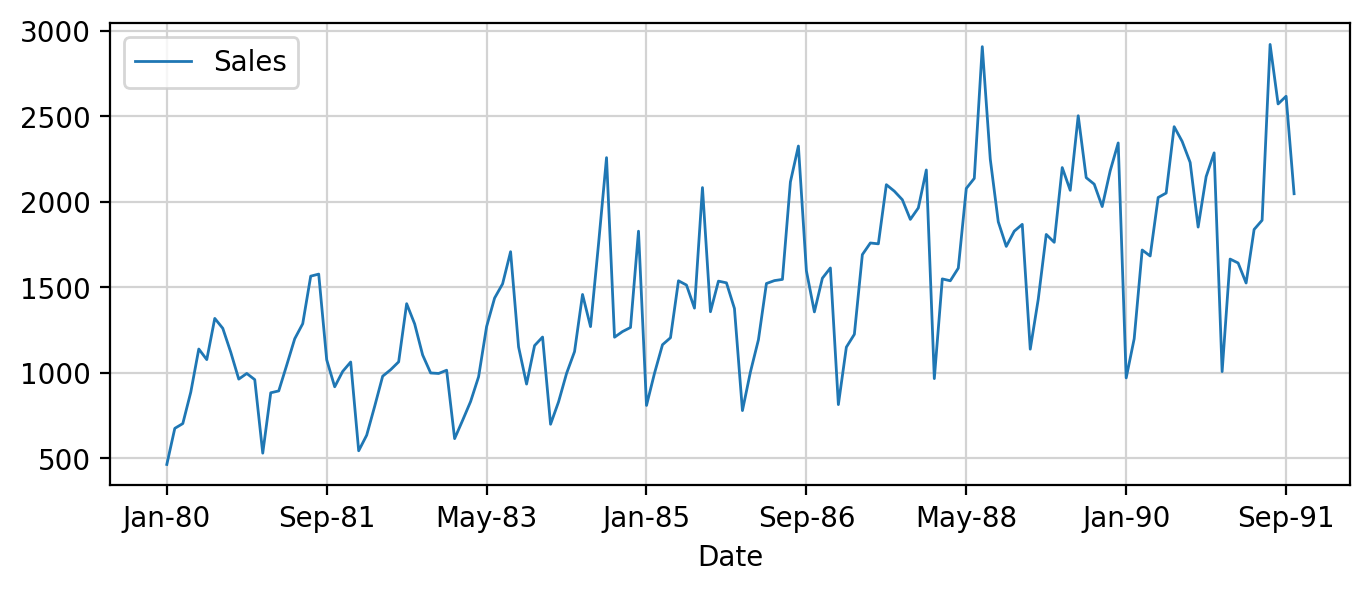

In [5]:
df.plot(
    x = 'Date',
    y = 'Sales'
)

**Interpreting the Australian Wine Sales Plot:**

This plot visually represents the monthly Australian red wine sales over time. We can clearly observe two key features:

1.  **Upward Trend:** There's a general increase in sales over the years, suggesting growing demand or perhaps population growth. This long-term movement is the *trend* component of the time series. For a business, identifying this trend is crucial for long-term planning and capacity forecasting.
2.  **Seasonal Pattern:** Notice the recurring peaks and troughs within each year. Sales tend to be higher in certain months and lower in others. This predictable, repeating pattern is the *seasonal* component. Understanding this seasonality is vital for inventory management, staffing, and marketing campaigns throughout the year. The peaks appear to be around July, and the troughs around January.

### More Time Series

#### NYC Accidents



Taking a look at the aggregate data for NYC accidents, we can start asking questions like:

* Does the trend look good?
* When do we observe spikes in accidents on a daily and weekly basis, so that we can deploy resources accordingly? (We can also do that on a geographical basis, but we will examine that separately)
* Which dates or times are unusually high or low?

In [ ]:
# Connect to the database
conn_string = 'mysql+pymysql://{user}:{password}@{host}/?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org',
    user = 'student',
    password = 'dwdstudent2025',
    encoding = 'utf8mb4')
mysql_engine = create_engine(conn_string)

# Get the number of accidents per hour
sql = '''
  SELECT date_format(DATE_TIME,'%Y-%m-%d %H:00') AS acc_date, COUNT(*) AS accidents
  FROM collisions.collisions
  GROUP BY date_format(DATE_TIME,'%Y-%m-%d %H:00')
  ORDER BY date_format(DATE_TIME,'%Y-%m-%d %H:00')
'''

# Read the results in Pandas
with mysql_engine.connect() as conn:
  acc_hourly = pd.read_sql(text(sql), con=conn)

# Convert the acc_date column to datetime
acc_hourly['acc_date'] = pd.to_datetime(acc_hourly['acc_date'])

acc_hourly.plot(
    kind='line',
    x='acc_date',
    y='accidents'
)

**Interpreting the NYC Hourly Accidents Plot:**

This plot shows the number of vehicular accidents in NYC recorded on an hourly basis. It's a much more granular view than the wine sales.

*   **Volatility:** Unlike the relatively smooth wine sales trend, this plot is quite volatile, showing significant fluctuations from hour to hour. This suggests that many factors influence accidents on a short time scale.
*   **Potential Patterns:** While it's hard to see clear long-term trends or strong daily seasonality at this resolution, we can observe periods of higher and lower activity. Later, by aggregating this data, we'll be able to reveal more distinct patterns. For city planners and emergency services, understanding these high-activity periods is critical for resource allocation.

We can change the granularity of the time series by calculating aggregate statistics:

In [ ]:
#### NYC Accidents Daily/Weekly/Monthly

acc_aggregated = acc_hourly.copy()

# When we want to perform resampling, we need the datetime to be the "index"
acc_aggregated = acc_aggregated.set_index('acc_date')

# Modify the aggregation here to get values for daily, weekly, monthly, etc
acc_aggregated = acc_aggregated.resample('1W').sum()

# Plot the aggregated data; by default, x-axis is the index
acc_aggregated.plot(
    kind='line',
    y='accidents'
)

**Interpreting the Aggregated NYC Accidents Plot (Weekly):**

By aggregating the hourly accident data to a weekly frequency, the plot becomes smoother and reveals clearer patterns.

*   **Smoothed Trend:** The weekly aggregation helps to smooth out the hourly noise and allows us to see the broader trend in accidents over time.
*   **Reduced Volatility:** The weekly sum reduces the day-to-day volatility, making it easier to identify underlying movements.
*   **Weekly Seasonality is Smoothed:** While there is likely weekly seasonality (more accidents on certain days of the week), aggregating to weekly sums will smooth out or hide this specific pattern. To see weekly seasonality, we would need to analyze the daily or hourly data differently. This highlights the importance of choosing the right aggregation level for the patterns you want to study. For transportation authorities, analyzing trends at different granularities helps inform policy and infrastructure decisions.

#### US Population

In [ ]:
# We use the thousands=',' option to properly convert the population numbers to integers
population = pd.read_csv("https://storage.googleapis.com/datasets_nyu/us-population.txt", sep=' ', thousands=',')
population["Year"] = pd.to_numeric(population["Year"])
population["US_Population"] = pd.to_numeric(population["US_Population"])

population.plot(
    kind = 'line',
    x = 'Year',
    y = 'US_Population',
    marker = 'o'
)

**Interpreting the US Population Plot:**

This plot shows the US population over a long period.

*   **Clear, Smooth Trend:** This is a classic example of a time series dominated by a strong, consistent upward trend. Population growth is generally a very smooth process over this time scale.
*   **Absence of Seasonality:** As expected, population data at this frequency (likely annual) does not show seasonality in the way sales or accidents might.
*   **Business Relevance:** Businesses operating in the US market would use this type of data for long-term market size forecasting and strategic planning.

#### Stock prices

If you are interested in downloading stock information, [this article contains a good discussion](https://towardsdatascience.com/a-comprehensive-guide-to-downloading-stock-prices-in-python-2cd93ff821d4).

In [6]:
stock_df = yf.download(tickers = ['GOOG','AAPL','MSFT', 'IBM'],
                       interval = '1d', # download daily prices
                       start='2005-01-01', # fetch prices after 2004
                       auto_adjust = True, # adjust for splits etc
                       progress = False # do not show a progress bar
                       )['Close'] # Keep only the closing price
display(stock_df)

Ticker,AAPL,GOOG,IBM,MSFT
Date,,,,
2005-01-03,0.951065,5.018992,50.577095,18.485226
2005-01-04,0.960832,4.815717,50.033821,18.554350
2005-01-05,0.969248,4.791205,49.930351,18.512877
2005-01-06,0.970000,4.668398,49.775131,18.492132
2005-01-07,1.040625,4.799623,49.557812,18.436836
...,...,...,...,...
2025-06-11,198.779999,178.789993,281.519989,472.619995
2025-06-12,199.199997,176.970001,281.029999,478.869995
2025-06-13,196.449997,175.880005,277.220001,474.959991


<Axes: title={'center': 'Daily Closing price'}, xlabel='Date'>

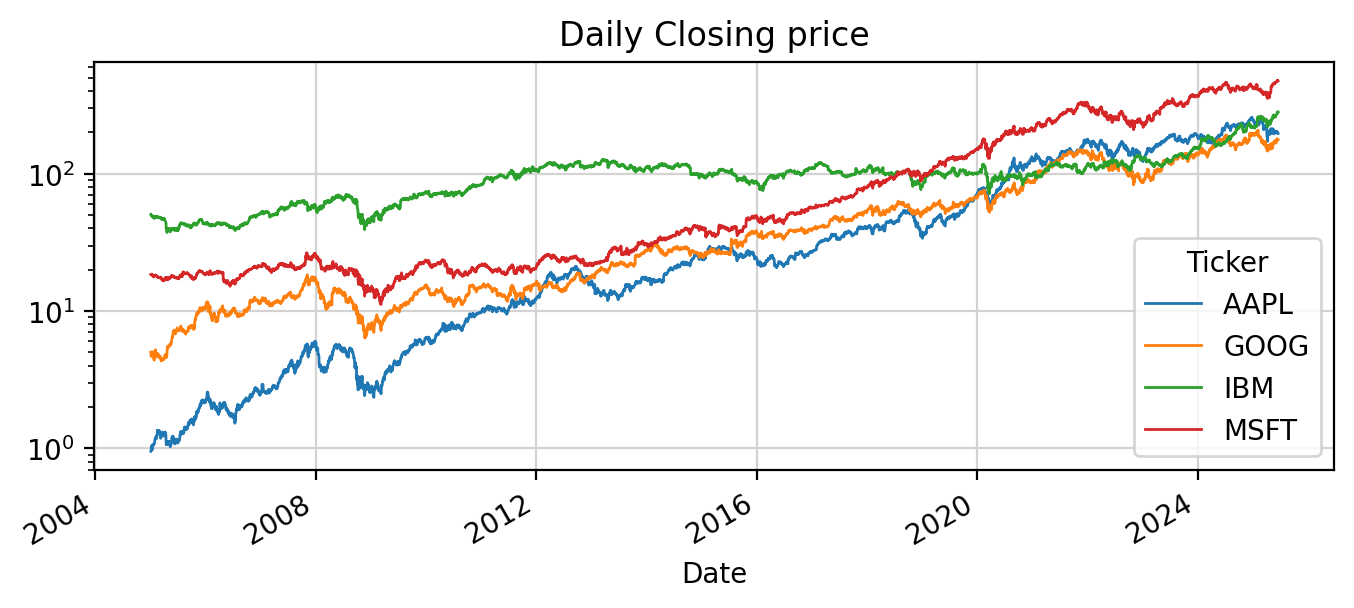

In [9]:
stock_df.plot(
    title="Daily Closing price",
    logy=True
)

**Interpreting the Daily Stock Closing Price Plot:**

This plot shows the daily closing prices for several major tech stocks.

*   **Upward Trend (Long-Term):** Over the long term, these stocks show a significant upward trend, reflecting overall market growth and the success of these specific companies.
*   **Volatility:** Stock prices are known for their volatility, with significant ups and downs from day to day. This is inherent in financial markets.
*   **Relative Performance:** While all show an upward trend, their relative performance and volatility differ. Comparing the steepness of the lines gives an initial idea of which stocks have grown faster. This plot is essential for investors to track asset performance and identify potential investment opportunities.
*   **Log Scale:** We used a log scale on the y-axis. This is common for financial data spanning long periods because it better represents percentage changes. Equal vertical distances on a log scale represent equal *percentage* changes, which is often more relevant for understanding investment growth than absolute dollar changes.

First date is 2005-01-03 00:00:00


<Axes: title={'center': 'Normalized Price (y=1 is at Jan 1 2005)'}, xlabel='Date'>

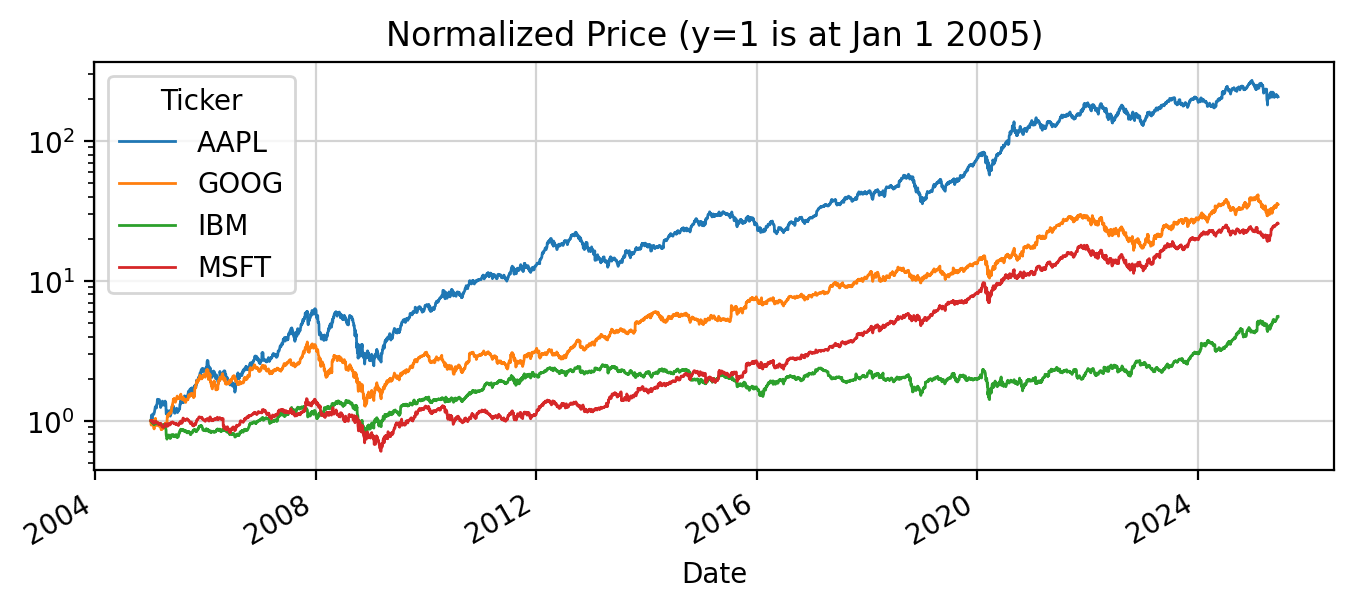

In [10]:
# Variation of the plot, where we normalize all stocks
# by dividing the stock with the price on the first day
# of 2005.
normalized_stock_df = stock_df.copy()
first_date = normalized_stock_df.index[0]
print("First date is", first_date)

first_entry = normalized_stock_df.loc[first_date]
normalized_stock_df = normalized_stock_df / first_entry

normalized_stock_df.plot(
    title="Normalized Price (y=1 is at Jan 1 2005)",
    logy=True
)

In [ ]:
normalized_stock_df.index[0]

**Interpreting the Normalized Stock Prices Plot:**

This plot shows the stock prices normalized to start at 1 on January 1, 2005.

*   **Direct Performance Comparison:** Normalizing the prices allows for a direct comparison of the *percentage* growth of each stock since the starting date. A value of 2 on this plot means the stock price has doubled since Jan 1, 2005.
*   **Identifying Outperformers/Underperformers:** It's much easier to see which stock has performed the best (the one highest on the plot) and which has performed the worst (the one lowest on the plot) relative to the starting point. This is invaluable for portfolio analysis and comparing investment strategies.
*   **Relative Volatility:** While the overall trend is normalized, the relative volatility of each stock is still visible.

In [11]:
# Daily returns
daily_returns = stock_df.pct_change(1)
display(daily_returns)

Ticker,AAPL,GOOG,IBM,MSFT
Date,,,,
2005-01-03,NaN,NaN,NaN,NaN
2005-01-04,0.010269,-0.040501,-0.010742,0.003739
2005-01-05,0.008759,-0.005090,-0.002068,-0.002235
2005-01-06,0.000776,-0.025632,-0.003109,-0.001121
2005-01-07,0.072810,0.028109,-0.004366,-0.002990
...,...,...,...,...
2025-06-11,-0.019194,-0.006777,0.019114,0.003610
2025-06-12,0.002113,-0.010179,-0.001741,0.013224
2025-06-13,-0.013805,-0.006159,-0.013557,-0.008165


In [12]:
daily_returns.describe()

Ticker,AAPL,GOOG,IBM,MSFT
count,5146.000000,5146.000000,5146.000000,5146.000000
mean,0.001245,0.000872,0.000440,0.000778
std,0.020407,0.018997,0.014569,0.017141
min,-0.179195,-0.116091,-0.128507,-0.147390
25%,-0.008334,-0.007928,-0.006289,-0.007175
50%,0.001101,0.000770,0.000517,0.000490
75%,0.011666,0.010096,0.007459,0.008985
max,0.153288,0.199915,0.129642,0.186047


<Axes: xlabel='Date'>

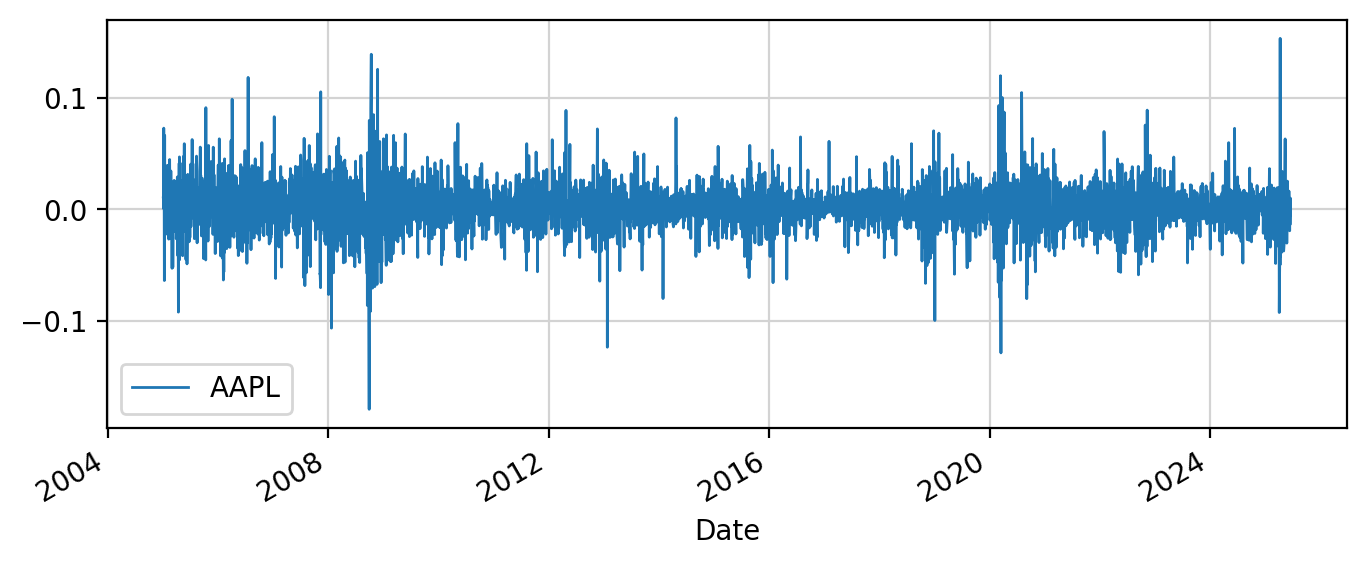

In [13]:
daily_returns.plot(
    y = 'AAPL'
)

**Interpreting the Daily Returns Plot (AAPL):**

This plot shows the daily percentage change (returns) for Apple stock.

*   **Zero Mean:** Unlike the price plot, the returns plot tends to fluctuate around zero. Daily stock returns are generally unpredictable and close to zero on average over short periods.
*   **Volatility/Spikes:** We can see periods of higher volatility (larger swings up and down) and occasional large spikes, which correspond to significant news events or market reactions.
*   **Absence of Clear Trend or Seasonality:** Daily returns typically do not exhibit strong trends or seasonality. They are often modeled as random processes, although with characteristics like volatility clustering (periods of high volatility followed by more high volatility). For quantitative analysts and risk managers, understanding the distribution and volatility of returns is fundamental.

<Axes: ylabel='Density'>

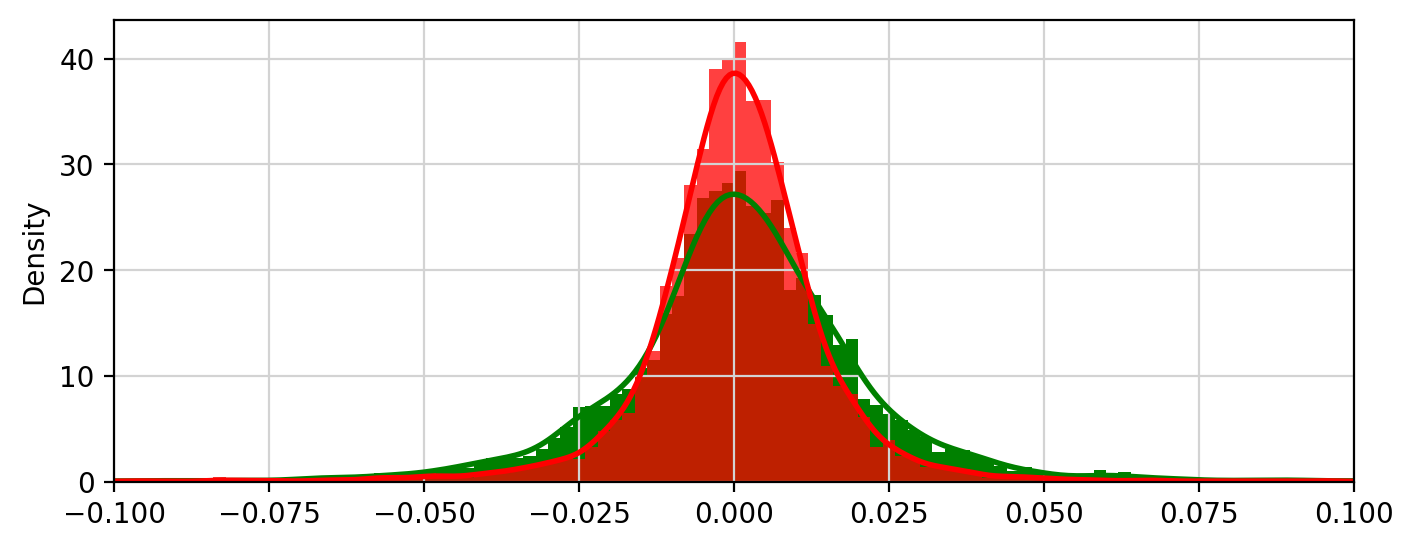

In [16]:
daily_returns['AAPL'].hist(bins=100, color='Green', alpha=1, density=True, range=(-0.1,0.1))
daily_returns['IBM'].hist(bins=100, color='Red', alpha=0.75, density=True, range=(-0.1,0.1))

# If you want to add the KDE lines, uncomment the lines below
daily_returns['AAPL'].plot.kde(color='Green', alpha=1, linewidth=2, xlim=(-0.1,0.1))
daily_returns['IBM'].plot.kde(color='Red', alpha=1, linewidth=2, xlim=(-0.1,0.1))


**Interpreting the Daily Returns Histograms:**

These histograms show the distribution of daily returns for Apple and IBM.

*   **Distribution Shape:** The shape of these histograms is often compared to a normal distribution (the classic bell curve). While they have a peak around zero (meaning most daily returns are close to zero), stock return distributions often have "fatter tails" than a normal distribution, meaning extreme positive or negative returns happen more frequently than a normal distribution would predict.
*   **Comparison:** Comparing the distributions of different stocks (AAPL vs. IBM here) can reveal differences in their risk profiles. A wider distribution (like AAPL's appears to be compared to IBM's in this range) suggests higher volatility and thus higher risk.
*   **Business Relevance:** Understanding the distribution of returns is critical for risk management, portfolio construction, and pricing financial derivatives. It helps quantify the probability of experiencing large gains or losses.

#### Exercise

* Create a plot of the stock price for a company of your choice.
* Bechmark the stock price on Jan 1, 2020 and see the performance before and after. (Hints: (a) you can use the command .loc['1976-05-03'] to get the value of a series on a particular date; (b) there is no trading on weekends and on holidays)
* Calculate the returns of the stock on a daily basis.
* How would you calculate the return on a coarser time granularity (e.g., weekly, monthly, etc)?

#### A more involved exercise

Here are several sector ETFs representing different areas of the economy. The ETFs below cover the 11 sectors of the Global Industry Classification Standard (GICS).

* Energy: XLE (Energy Select Sector SPDR Fund). Includes oil, gas, and renewable energy companies
* Financials: XLF (Financial Select Sector SPDR Fund). Represents banks, insurance companies, and other financial services firms
* Healthcare: XLV (Health Care Select Sector SPDR Fund). Covers pharmaceutical companies, medical device manufacturers, and healthcare providers
* Consumer Staples: XLP (Consumer Staples Select Sector SPDR Fund). Includes companies producing essential consumer goods like food, beverages, and household items
* Consumer Discretionary: XLY (Consumer Discretionary Select Sector SPDR Fund). Represents companies producing non-essential goods and services, like retail, automotive, and entertainment
* Materials: XLB (Materials Select Sector SPDR Fund). Covers companies involved in the production of raw materials, chemicals, and construction materials
* Real Estate: XLRE (Real Estate Select Sector SPDR Fund). Includes REITs and other real estate companies
* Industrials: XLI (Industrial Select Sector SPDR Fund). Represents manufacturing, aerospace, defense, and transportation companies
* Communication Services: XLC (Communication Services Select Sector SPDR Fund) Includes telecommunication, media, and entertainment companies
* Utilities: XLU (Utilities Select Sector SPDR Fund)
* Tech: XLK (Tech Select Sector SPDR Fund). Covers technology companies

***Tasks***

* Download the ETF prices since Jan 1, 2000.
* Normalize their prices and plot how the ETF prices have evolved since 2000.
* Calculate the daily returns of the ETFs and store them in a dataframe `returns_etf`
* Use the `.describe()` command to calculate the risk profile and the returns of each sector. Which sector has performed best, which one has performed the worse?
* Use the `.corr()` to calculate the degree of correlations of the returns across sectors.
* Use the `seaborn.heatmap` to visualize the correlation matric across sectors.
* Use the `seaborn.pairplot(... kind='reg')` to create pairwise scatterplots that show the correlation of the returns using scatterplots. Here is a command that makes the regression line red, and makes the scatterplots more transparent.
`sns.pairplot(returns, kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.01}})`


In [18]:
all_etf_tickers = ['XLK', 'XLU', 'XLE', 'XLF', 'XLV', 'XLP', 'XLY', 'XLB', 'XLRE', 'XLI', 'XLC']
all_etf_names = ['Tech', 'Utilities', 'Energy', 'Financials', 'Healthcare', 'Consumer Staples', 'Consumer Discretionary', 'Materials', 'Real Estate', 'Industrials', 'Communication Services']

In [19]:
few_etf_tickers = ['XLK', 'XLRE',  'XLE', 'XLF', 'XLV']
few_etf_names = ['Tech', 'Real Estate', 'Energy', 'Financials', 'Healthcare']

In [ ]:
# Create a "returns_etf" by calculating the daily pct_change of the ETFs
# and then examine their correlations

# returns_etf.corr()

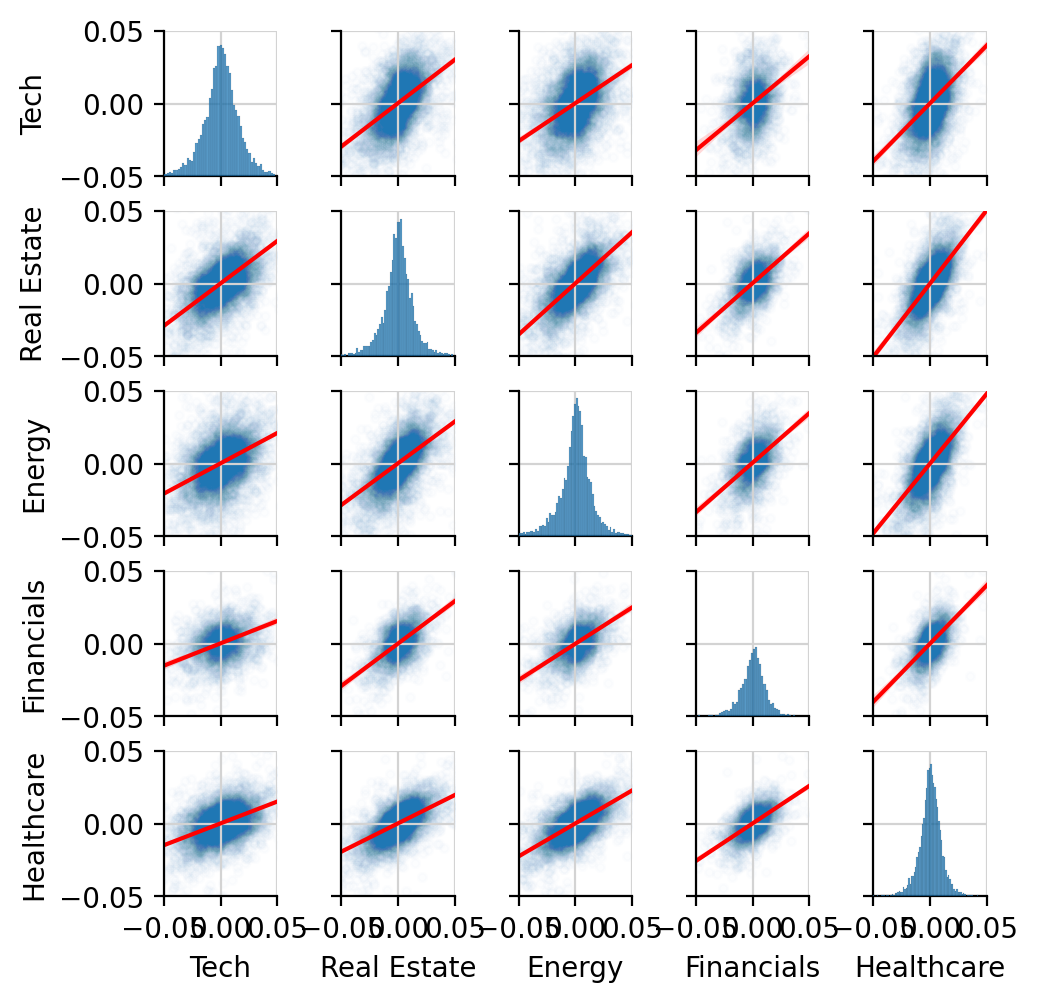

In [23]:
stock_df = yf.download(tickers = few_etf_tickers,
                       interval = '1d', # download daily prices
                       start='2000-01-01', # fetch prices after 2004
                       auto_adjust = True, # adjust for splits etc
                       progress = False # do not show a progress bar
                       )['Close'] # Keep only the closing price
returns_etf = stock_df.pct_change(1)
returns_etf.columns = few_etf_names
returns_etf.corr()

import seaborn as sns
g = sns.pairplot(
      returns_etf,
      kind='reg',
      plot_kws={
          'line_kws':{'color':'red'},
          'scatter_kws': {'alpha': 0.01}
      },
      height=1,
      aspect=1
    )

# Iterate through the axes and set the limits
for ax in g.axes.flat:
    ax.set_xlim(-0.05, 0.05)
    ax.set_ylim(-0.05, 0.05)

#### FRED Economic Data

The [FRED Economic Data by the Federal Reserve Bank of St Louis](https://fred.stlouisfed.org/) publishes a rich set of 822,000 US and international time series from 110 sources. Here are a few examples:

In [24]:
fred = Fred(api_key='c041995ed8b9ab9c3f475e2ca8f7c288')

In [25]:
# Consumer Price Index for All Urban Consumers, not seasonally-adjusted
# https://fred.stlouisfed.org/series/CPIAUCNS

cpi = fred.get_series('CPIAUCNS')

In [28]:
cpi

,0
1913-01-01,9.800
1913-02-01,9.800
1913-03-01,9.800
1913-04-01,9.800
1913-05-01,9.700
...,...
2025-01-01,317.671
2025-02-01,319.082
2025-03-01,319.799
2025-04-01,320.795


In [26]:
# Access the CPI value on a specific date
print(cpi.loc['2010-01-01'])

216.687


<Axes: >

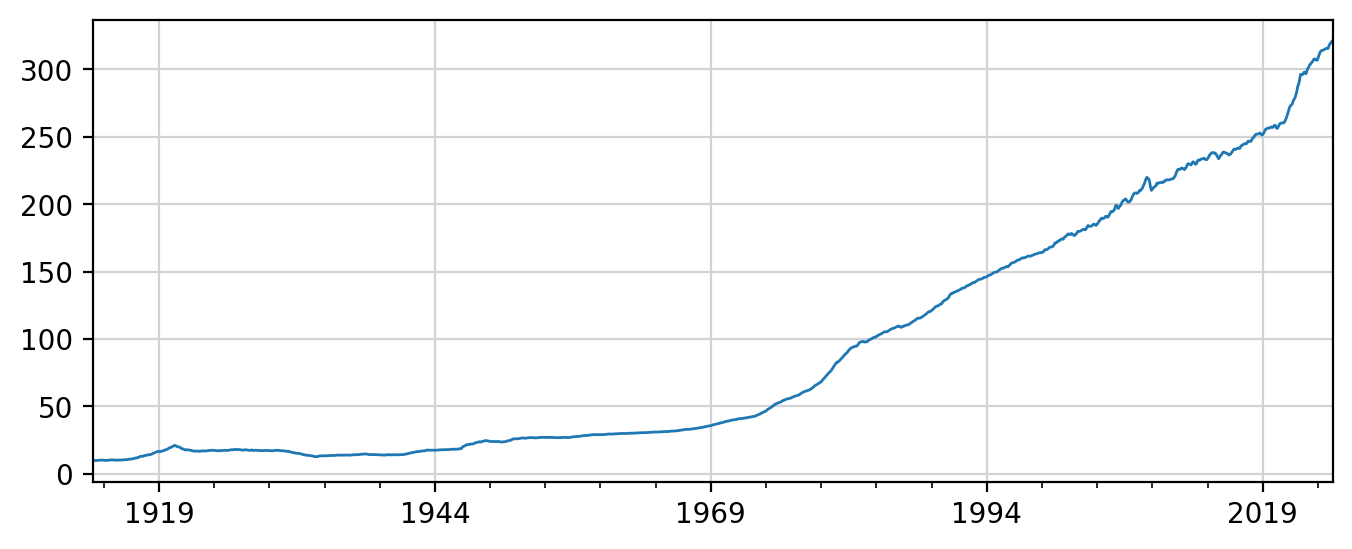

In [27]:
cpi.plot()

**Interpreting the Consumer Price Index (CPI) Plot:**

This plot shows the Consumer Price Index, a key measure of inflation.

*   **Upward Trend:** There is a clear and persistent upward trend in the CPI over time, indicating that the general price level of goods and services has increased significantly. This is inflation.
*   **Varying Slope:** The slope of the curve isn't constant; there are periods where inflation was higher (steeper slope) and periods where it was lower (flatter slope).
*   **Business and Economic Relevance:** Tracking CPI is essential for businesses (for pricing strategies, cost management, and wage negotiations) and for economists and policymakers (to monitor inflation, set monetary policy, and understand purchasing power).

<Axes: >

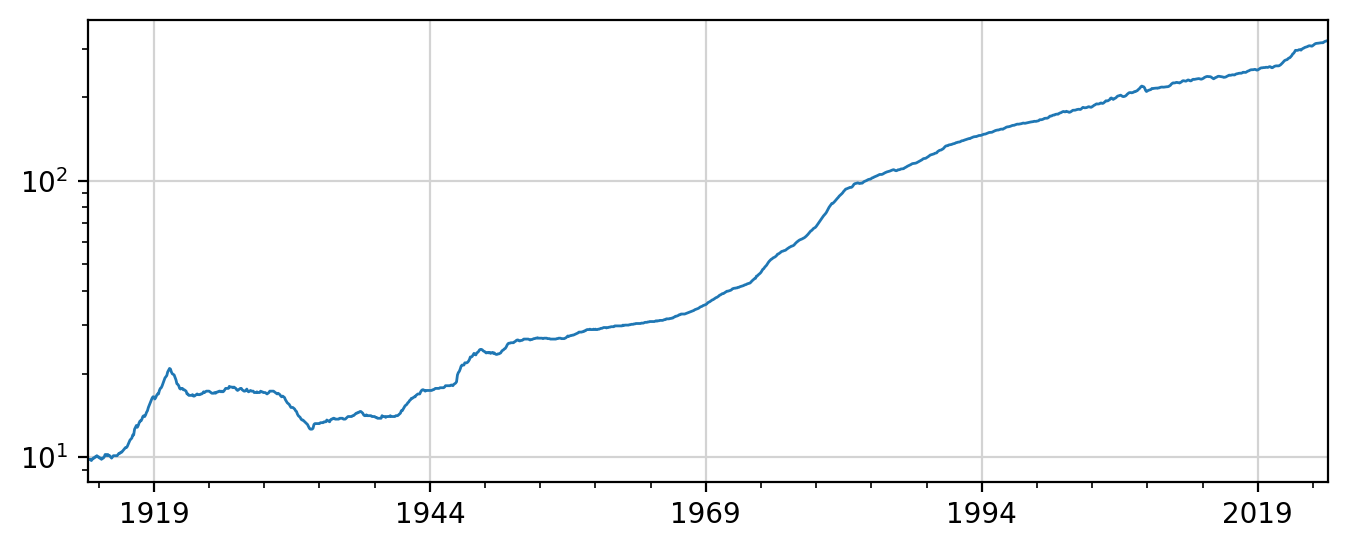

In [29]:
# Price increases compound and increase exponentially,
# so we need log-scale to understand price increases better
# (It was the same with the stock prices)
cpi.plot(logy=True)

**Interpreting the CPI Plot (Log Scale):**

Plotting the CPI on a log scale changes how we perceive the trend.

*   **Percentage Changes:** On a log scale, a straight line indicates a constant *percentage* growth rate. Deviations from a straight line show periods where the inflation rate was accelerating or decelerating.
*   **Better Visualization of Early Periods:** The log scale compresses the later values, making the relative changes in the earlier periods more visible. This helps in analyzing historical inflation dynamics.
*   **Compounding Effect:** The log scale inherently visualizes the compounding nature of inflation, where price increases build upon previous increases.

<Axes: >

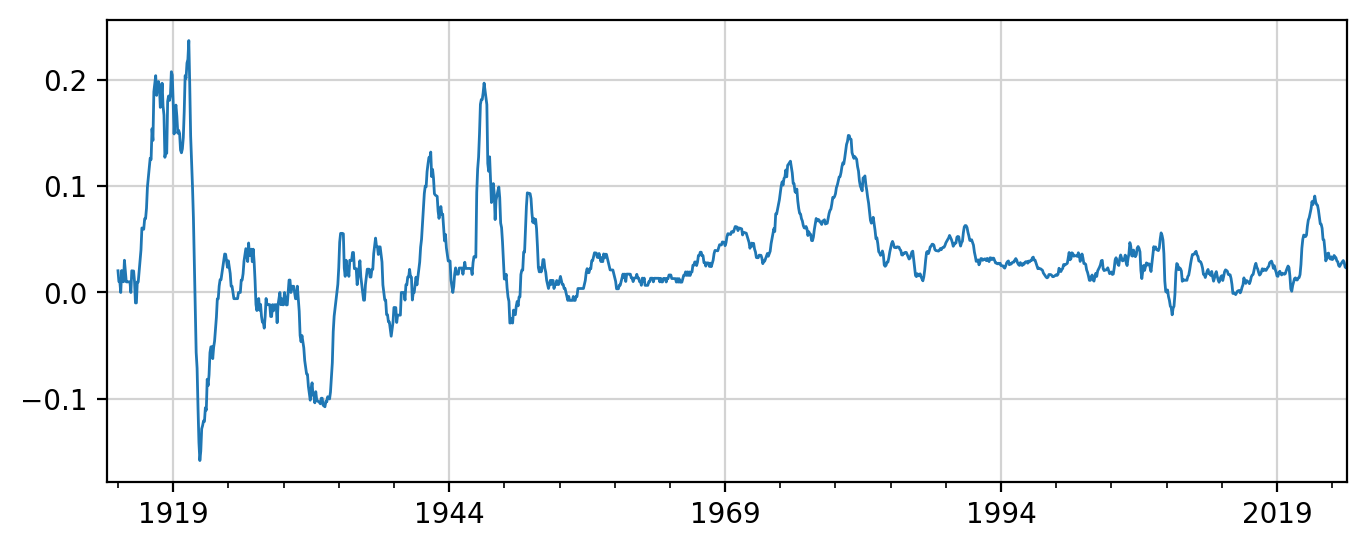

In [30]:
# CPI data is monthly. The code below
# calculates the 12-month percentage change
cpi.pct_change(12).plot()

**Interpreting the CPI 12-Month Percentage Change Plot:**

This plot shows the year-over-year percentage change in the CPI, which is the standard way inflation is often reported.

*   **Inflation Rate:** This plot directly shows the annual inflation rate. We can see periods of high inflation (peaks) and low inflation (troughs).
*   **Volatility:** The inflation rate is more volatile than the absolute CPI level.
*   **Identifying Inflationary/Deflationary Periods:** Periods where the line is above zero indicate inflation, while periods below zero (though less common in this dataset) would indicate deflation.
*   **Key Economic Indicator:** This is a critical plot for understanding the macroeconomic environment. Central banks closely monitor this to make decisions about interest rates. Businesses use it to understand the changing cost of goods and the impact on consumer purchasing power.

### Normalization of time series (Exercise)

* Retrieve and plot the [Advance Retail Sales: Retail Trade and Food Services](https://fred.stlouisfed.org/series/RSAFSNA)
* Normalize the values, to account for inflation. Use the CPI time series.

<Axes: >

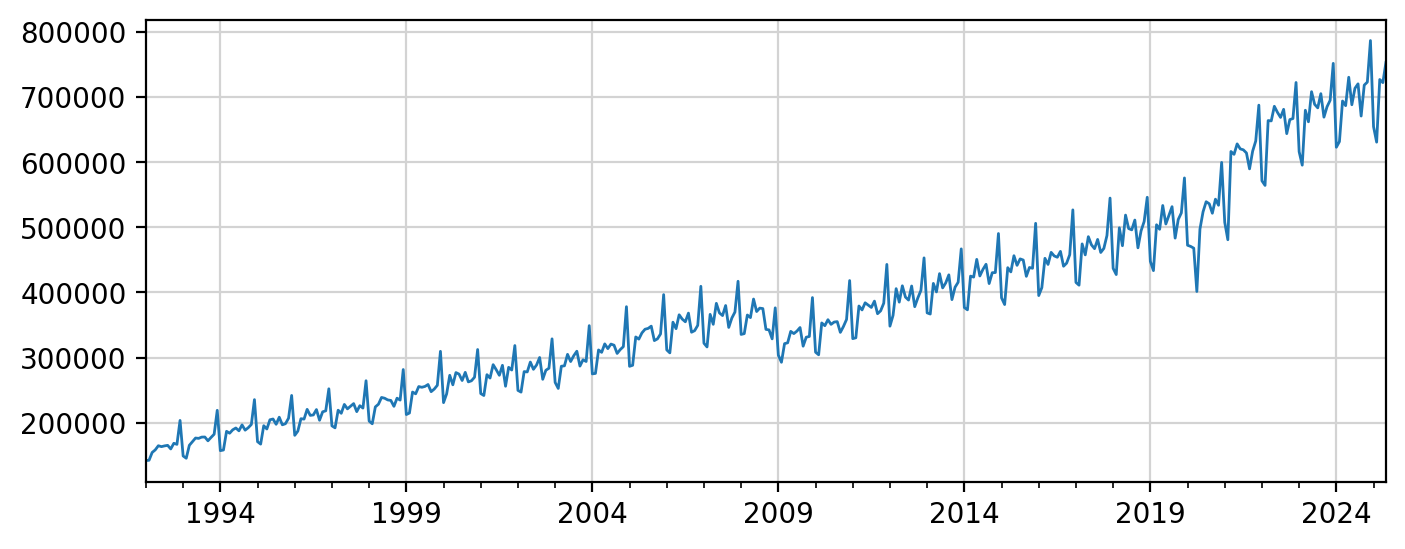

In [31]:
retail = fred.get_series('RSAFSNA')

retail.plot()

* Retrieve and plot the S&P 500 index from Yahoo Finance. Its code is `'^GSPC'`; use the closing price for each date.
* To evaluate its performance in the 21st century, divide the time series with its value in January 2000. (Hints: (a) you can use the command `.loc['1976-05-03']` to get the value of a series on a particular date; (b) there is no trading on weekends and on holidays)
* Use the CPI values to examine the performance of the S&P500 after accounting for inflation. (Hint: Notice that the time series have different temporal granularity; think how to make them comparable)

<Axes: >

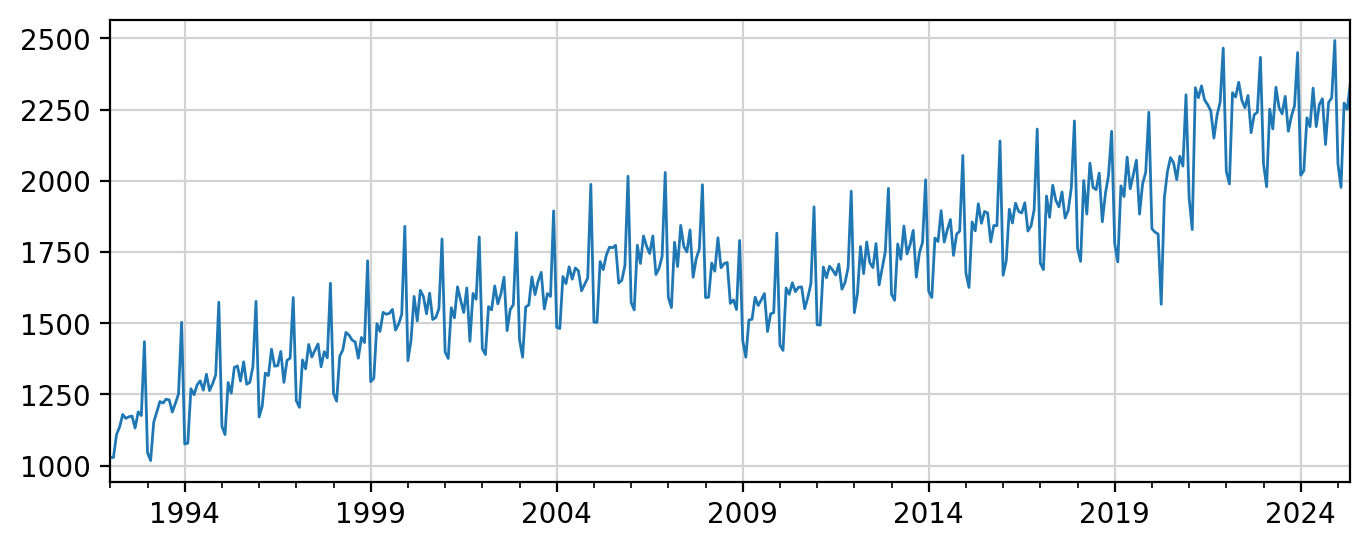

In [32]:
retail_nomalized = retail / cpi
retail_nomalized.dropna().plot()

## Analyzing Time Series: Autocorrelation

A commonly analyzed property of a time series is the **autocorrelation** of the sequential observations. Simply stated, a high degree of autocorrelation means that if we know the value at time $t$, we can predict well the value at $t+1$.

Using the `autocorr` function, we estimate the autocorrelation of our `Sales` time series:

In [38]:
# Load the wine sales data
url = "https://storage.googleapis.com/datasets_nyu/australian-wine-sales.txt"
df = pd.read_csv(url, sep='\t')

# Converting the string date to proper datetime format
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")
# Ensuring that sales is a numeric variable
df["Sales"] = pd.to_numeric(df["Sales"])


<ipython-input-38-687300578>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])


In [39]:
df["Sales"].autocorr()

np.float64(0.7367146692936072)

The concept of autocorrelation can extend to longer time periods, and not just to $t$ and $t+1$. We can extract autocorrelation for various **lag** values.

In [40]:
df["Sales"].autocorr(lag=1) # same as simply df["Sales"].autocorr()

np.float64(0.7367146692936072)

In [41]:
# Correlation between t and t+2
# ie sales now and 2 months later
df["Sales"].autocorr(lag=2)

np.float64(0.6024360861159858)

In [42]:
# Correlation between t and t+3
# ie sales now and 3 months later
df["Sales"].autocorr(lag=3)

np.float64(0.5104183331557987)

### Lag plots and  autocorrelation plots

Pandas provides two types of plots that can be used for the analysis of time series: the `lag_plot` and the `autocorrelation_plot`. We can also use the seasonal decomposition functionality of `statsmodels` to separate the time series into a trend, seasonal component, and residual noise. We will go quickly over these for now, mainly for demo purposes. Proper treatment of these topics require deeper analysis.



#### Lag plot

By default, the lag plot shows the value of the series at time $t$ vs. its value at time $t+1$. If there is no dependency (i.e., the time series is noise) then the lag plot is a scatterplot without any sign of correlation. If we can see a pattern and a correlation, then the series exhibits autocorrelation. For example, below we can see that there is a rather strong correlation of the two variables, indicating that the sales in time $t+1$ is similar to the sales at time $t$.

<Axes: xlabel='y(t)', ylabel='y(t + 12)'>

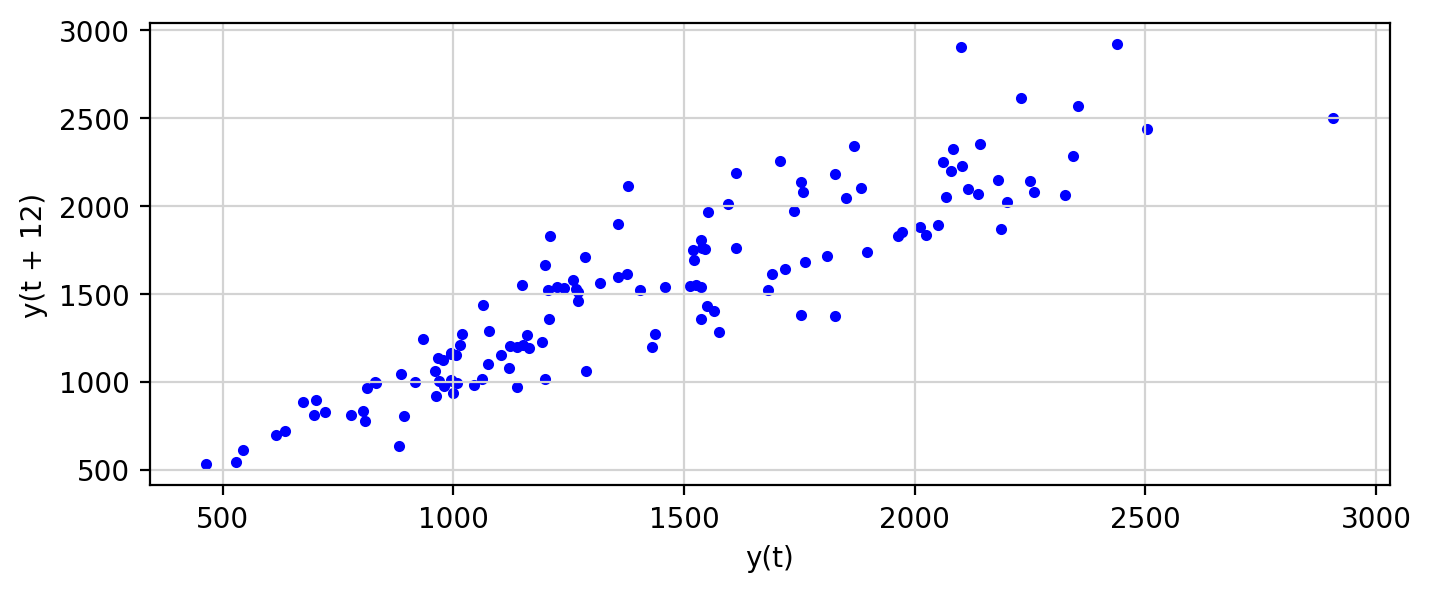

In [47]:
pd.plotting.lag_plot(df["Sales"], lag = 12, c='b')

In [46]:
# The plot above shows the autocorrelation of the t and t+1
# is around 0.73
df["Sales"].autocorr(lag=1)

np.float64(0.7367146692936072)

Here is the lag plot, where we plot $t$ and $t+12$. Notice that we have a higher correlation (less spread out points)

<Axes: xlabel='y(t)', ylabel='y(t + 12)'>

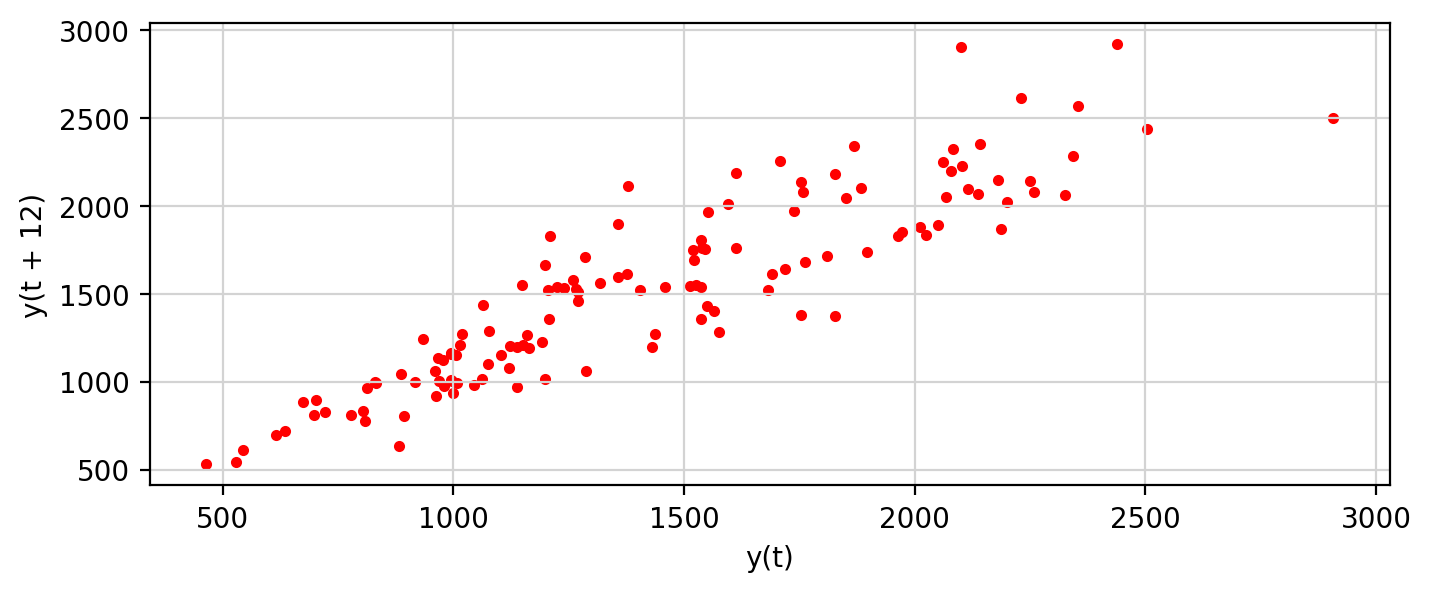

In [35]:
pd.plotting.lag_plot(df["Sales"], lag = 12, c='r')

In [36]:
df["Sales"].autocorr(lag=12)

np.float64(0.903237336203241)

Let's plot the two of them together.

<Axes: xlabel='y(t)', ylabel='y(t + 12)'>

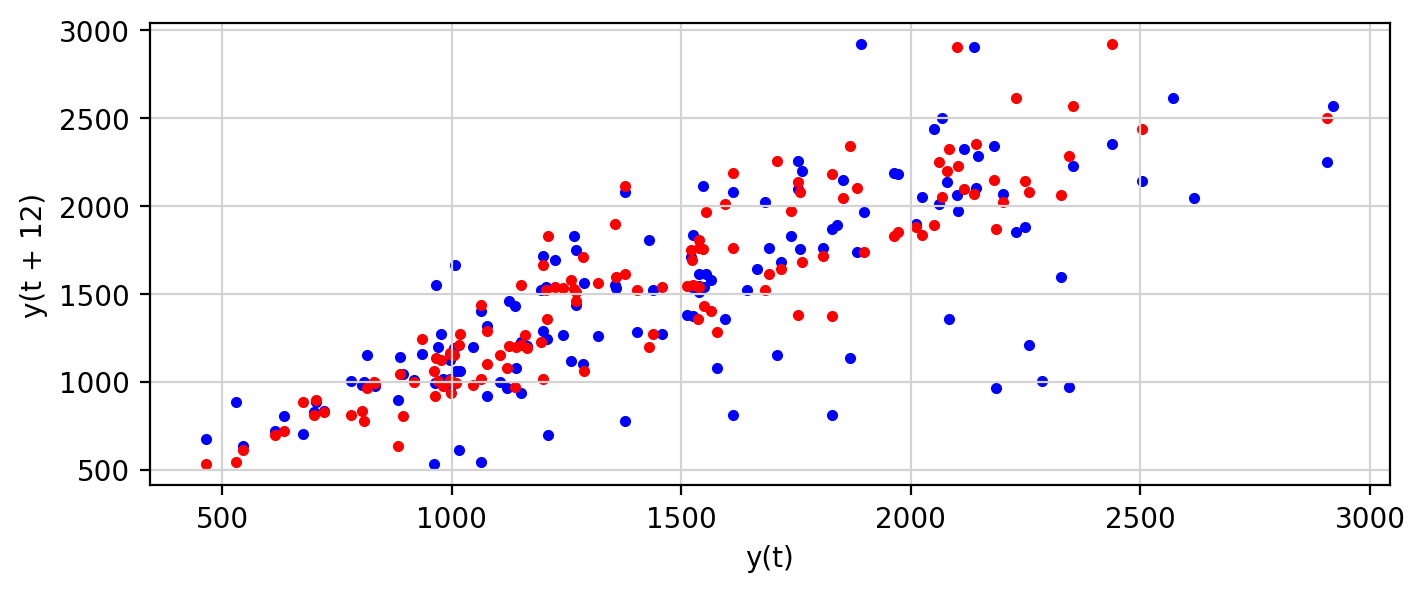

In [37]:
pd.plotting.lag_plot(df["Sales"], lag = 1, c='b')
pd.plotting.lag_plot(df["Sales"], lag = 12, c='r')

#### Interactive Lag Plot

And here is a more interactive plot that allows you to change the lag value using a slider

In [53]:
#import ipywidgets as widgets
#import matplotlib.pyplot as plt
#import seaborn as sns
#import pandas as pd

#lag = widgets.IntSlider(min=1,max=36,value=12)

#def update_plot(l):
    #fig, ax = plt.subplots(figsize=(5, 5)) # Create a new figure and axes
    # Create a DataFrame for regplot with lagged data
    #lagged_data = pd.DataFrame({
      #  'y(t)': df['Sales'],
      #  f'y(t + {l})': df['Sales'].shift(-l)
    #}).dropna() # Drop rows with NaN values created by shifting

  #  if not lagged_data.empty:
       # sns.regplot(x='y(t)', y=f'y(t + {l})', data=lagged_data, scatter_kws={'color': 'b'}, line_kws={'color': 'red'}, ax=ax)
      #  ax.set_title(f'Lag Plot with Regression Line (Lag = {l})')
      #  ax.set_xlabel('y(t)')
      #  ax.set_ylabel(f'y(t + {l})')
       # ax.set_xlim(500, 3000) # Set x-axis limits
     #   ax.set_ylim(500, 3000) # Set y-axis limits
       # ax.grid(True)
      #  plt.show()
   # else:
    #    print(f"No data available for lag = {l}")
     #   plt.close(fig) # Close the empty figure

#widgets.interact(update_plot, l=lag)

#### Autocorrelation Plot

In a more general setting, we want to also see if the value of the series at time $t$ is predictive of the value at time $t+n$. Such dependency would indicate that there is *autocorrelation* in the series. The autocorrelation plot shows the correlation value for various values of $n$.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

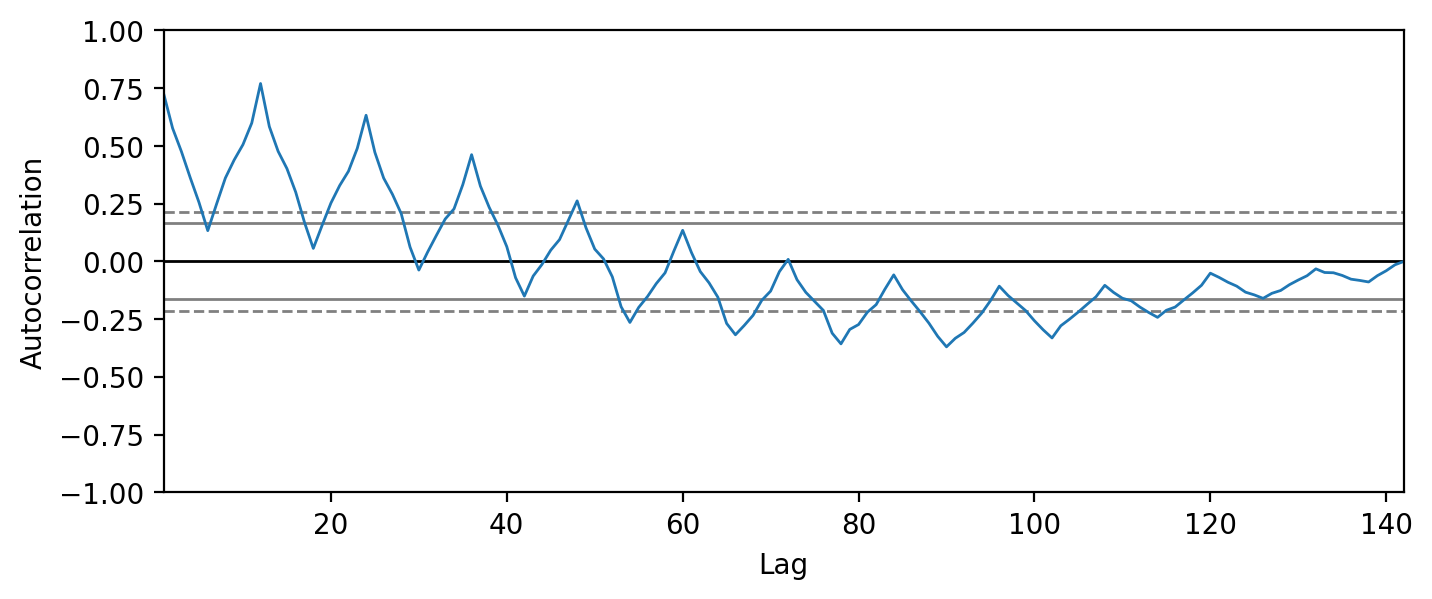

In [49]:
pd.plotting.autocorrelation_plot(df["Sales"])

**Interpreting the Autocorrelation Plot (Australian Wine Sales):**

This plot, also known as the Autocorrelation Function (ACF) plot, shows the correlation of the time series with lagged versions of itself. The x-axis represents the lag (the number of time steps between observations being correlated), and the y-axis represents the autocorrelation coefficient (ranging from -1 to 1).

*   **High Correlation at Small Lags:** The high autocorrelation at lag 1 (and other small lags) indicates that sales in one month are strongly correlated with sales in the immediately preceding months. This suggests a smooth, trending series.
*   **Significant Peaks at Lag 12 and its Multiples:** The prominent peaks at lag 12, 24, 36, etc., confirm the strong *seasonal* pattern we observed in the initial plot. The sales are highly correlated with sales from the same month in previous years. The fact that these peaks are positive and significant indicates a consistent annual cycle.
*   **Dampening Autocorrelation:** The autocorrelation generally decreases as the lag increases, but the seasonal peaks persist.
*   **Business Insight:** This plot provides quantitative evidence of the strong seasonality and trend in wine sales. It tells a business that past sales (especially 12 months ago) are very good predictors of current sales, which is crucial for accurate seasonal forecasting and inventory management. The blue shaded area represents the confidence interval; if the bars extend beyond this area, the autocorrelation is statistically significant.

Let's see next how we can extract the seasonal component.

### Exercise

Analyze the autocorrelation of the following series:

* NYC Accidents (`acc_hourly` and `acc_aggregated` (weekly) data frames)

* Stock prices (`normalized_stock_df` and `daily_returns`)

* Monthly CPI data from FRED (`cpi`)

## Trend and Seasonal Decomposition



In time series analysis, trend and seasonal decomposition are crucial to understand underlying patterns and recurring variations in your data. These methodologies enable better forecasting and decision-making, equipping you with a robust toolkit to leverage temporal data for business strategy. Let's dive deeper into how these methods can help us to effectively dissect and interpret our time series data.

In [50]:
# A simple technique for decomposition.
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
# Uses moving averages to calculate the trend
from statsmodels.tsa.seasonal import seasonal_decompose

# We decompose assumming a 12-month periodicity.
# We can also specify a multiplicative instead of an additive model
# The additive model is Y[t] = T[t] + S[t] + e[t]
# The multiplicative model is Y[t] = T[t] * S[t] * e[t]
decomposition = seasonal_decompose(
    x = df['Sales'],
    model='multiplicative',
    period=12,
    extrapolate_trend=24
)

<Figure size 1000x800 with 0 Axes>

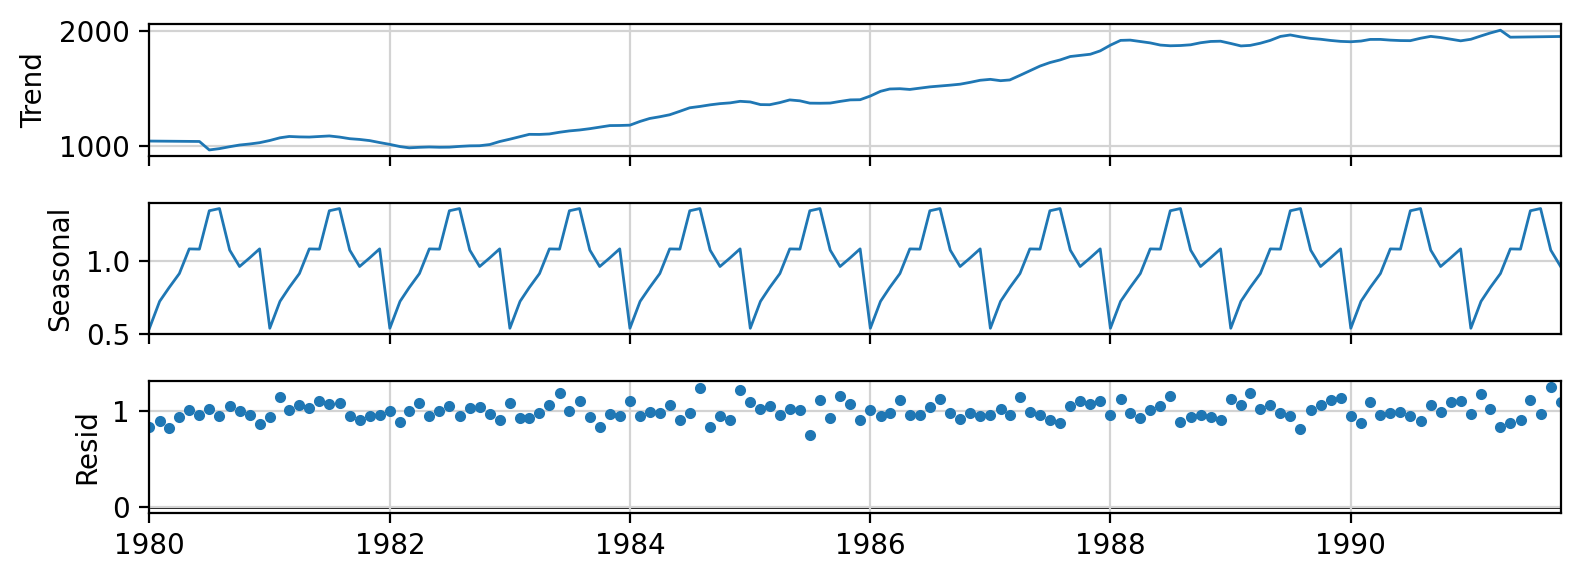

In [51]:
fig = plt.figure(figsize = (10,8))
fig = decomposition.plot(
    observed=False,
    seasonal=True,
    trend=True,
    resid=True,
)

**Interpreting the Time Series Decomposition Plot (Australian Wine Sales):**

This plot breaks down the original time series into its estimated components: Trend, Seasonal, and Residual.

*   **Observed:** (If included) This is the original time series data.
*   **Trend:** This line represents the underlying long-term movement in sales, with the seasonality smoothed out. It clearly shows the steady growth in wine sales over the period. For businesses, isolating the trend helps in understanding fundamental growth drivers and making long-term strategic decisions, free from seasonal noise.
*   **Seasonal:** This plot shows the recurring seasonal pattern, repeated for each year. It clearly highlights the months with typically higher and lower sales within a year. This component is essential for short-term planning, such as optimizing staffing levels, managing supply chains, and timing marketing promotions to coincide with expected peak demand.
*   **Residual:** Also called the "remainder" or "noise," this is what's left after the trend and seasonal components have been removed from the original series. Ideally, the residuals should look like random noise with no discernible pattern. Any patterns or large spikes in the residuals might indicate unusual events (outliers) or components of the time series that were not captured by the trend or assumed seasonality. Analyzing residuals helps identify anomalies that require further investigation.

#### Accessing indinvidual components of the decomposition

Once we have the decomposed time series model, we can also access the different components.

For example, we can get the trend of the time series, after removing the seasonality component:

In [54]:
# The outcome is a pandas Series, which is effectively the same as a single column of dataframe
decomposition.trend

,trend
Date,
1980-01-01,1043.275962
1980-02-01,1042.552853
1980-03-01,1041.829744
1980-04-01,1041.106635
1980-05-01,1040.383526
...,...
1991-06-01,1945.675769
1991-07-01,1946.919487
1991-08-01,1948.163205


<Axes: xlabel='Date'>

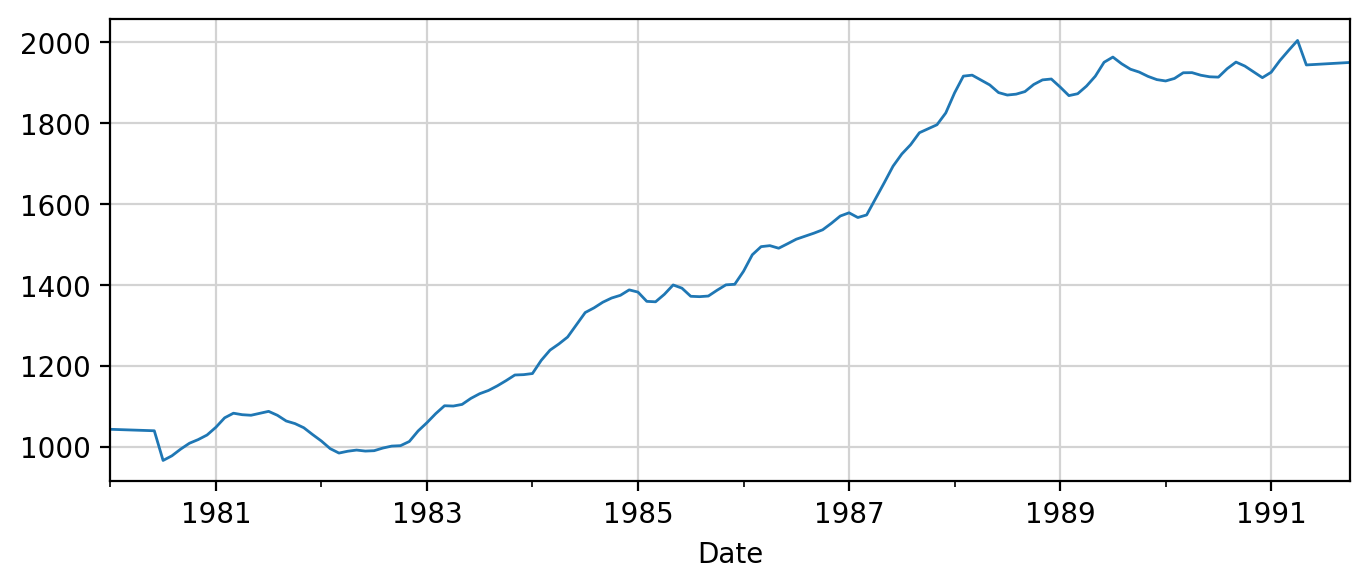

In [55]:
decomposition.trend.plot()

#### Periodogram (optional, advanced)

The periodogram is a graph that identifies the most important periodicities in the data. **We typically apply that to a timeseries with zero trend**. After that, we can extract the time periods to consider for periodicities. For most data, daily, weekly, and yearly are the three periods that we consider. In rare cases, a periodogram will reveal additional patterns.

<Axes: xlabel='period', ylabel='Power Spectral Density'>

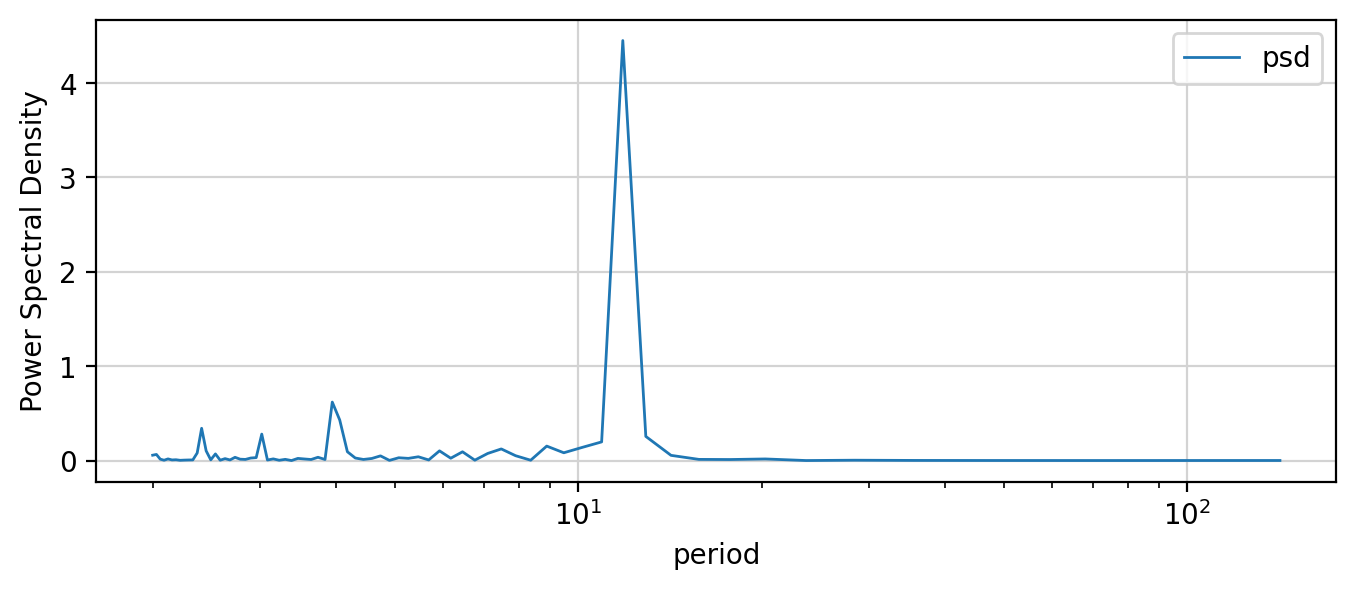

In [56]:
import numpy as np
from scipy.signal import periodogram
import matplotlib.pyplot as plt

# Create  a periodogram from the detrended sales time series
timeseries = df["Sales"] / decomposition.trend
freqs, psd = periodogram(timeseries)

# Create a dataframe with the results, and convert
# frequencies to time between events (periods)
# Remember that frequency = time per unit time (eg "2 times per month")
# and period is the inverse (e.g., "every half month")
prd = pd.DataFrame({"freqs": freqs, "psd": psd})
prd['period'] = 1/prd['freqs']

# Plot the results. Often people do a log on the y-axis, but
# for identifying the major components, I think that linear works
# better
prd.plot(
    x='period',
    y = 'psd',
    ylabel = 'Power Spectral Density',
    logx=True,
    # logy=True
)

## Exercise

* Below we fetch the daily number of vehicular accidents in NYC.
* Examine the autocorrelation structure of the accidents.
* Perform a decomposition of the time series into a trend, seasonal, and residual component.
* Try out both the additive and the multiplicative approach for the decomposition. Try to interpret and understand the difference in the reported seasonal component.
* Instead of counting accidents, extract the number of injuries and perform the same analysis.

In [57]:
conn_string = 'mysql+pymysql://{user}:{password}@{host}/{db}?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org',
    user = 'student',
    password = 'dwdstudent2025',
    db = 'collisions',
    encoding = 'utf8mb4')

mysql_engine = create_engine(conn_string)

sql = '''
  SELECT date_format(DATE_TIME,'%Y-%m-%d') AS acc_date, COUNT(*) AS accidents
  FROM collisions.collisions
  GROUP BY date_format(DATE_TIME,'%Y-%m-%d')
  ORDER BY date_format(DATE_TIME,'%Y-%m-%d')
'''

with mysql_engine.connect() as conn:
  acc = pd.read_sql(text(sql), con=conn)
acc['acc_date'] = pd.to_datetime(acc['acc_date'])
acc = acc.set_index('acc_date')

<Axes: xlabel='acc_date'>

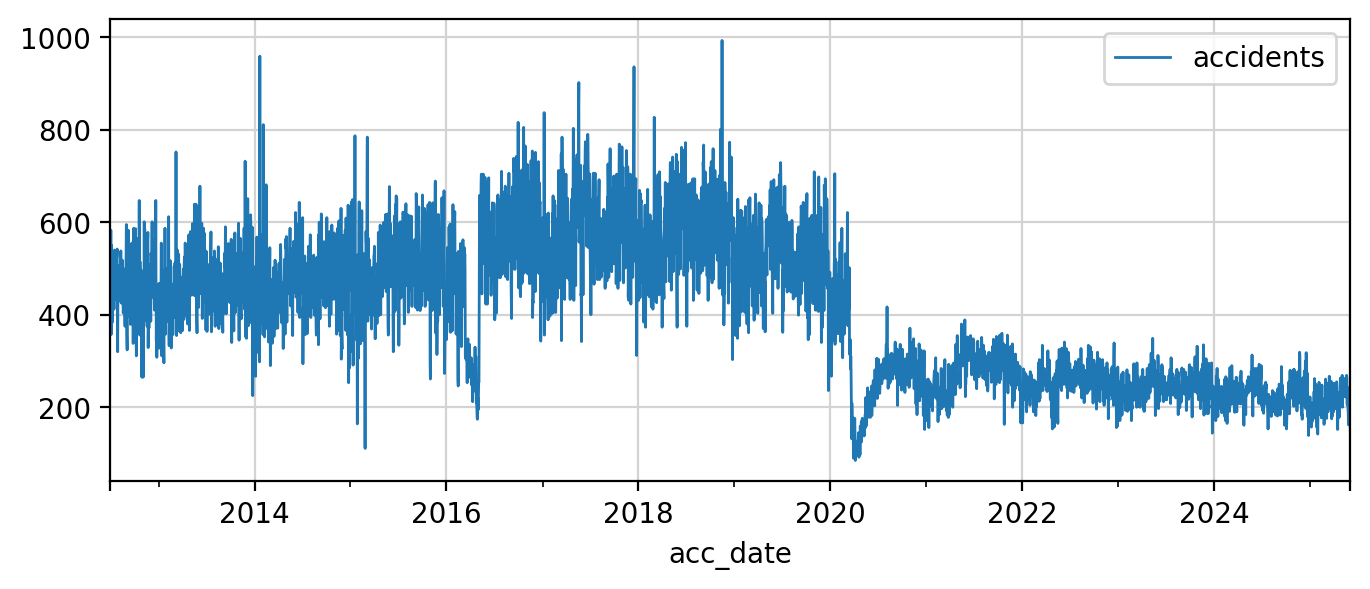

In [58]:
acc.plot()

In [ ]:
# Examine the autocorrelation

### Solution

In [59]:
acc['accidents'].autocorr()

np.float64(0.8763994551305395)

In [60]:
acc['accidents'].autocorr(lag=2)

np.float64(0.8195663487471542)

In [61]:
acc['accidents'].autocorr(lag=7)

np.float64(0.8828338078175664)

In [62]:
acc['accidents'].autocorr(lag=365)

np.float64(0.6760357543227113)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

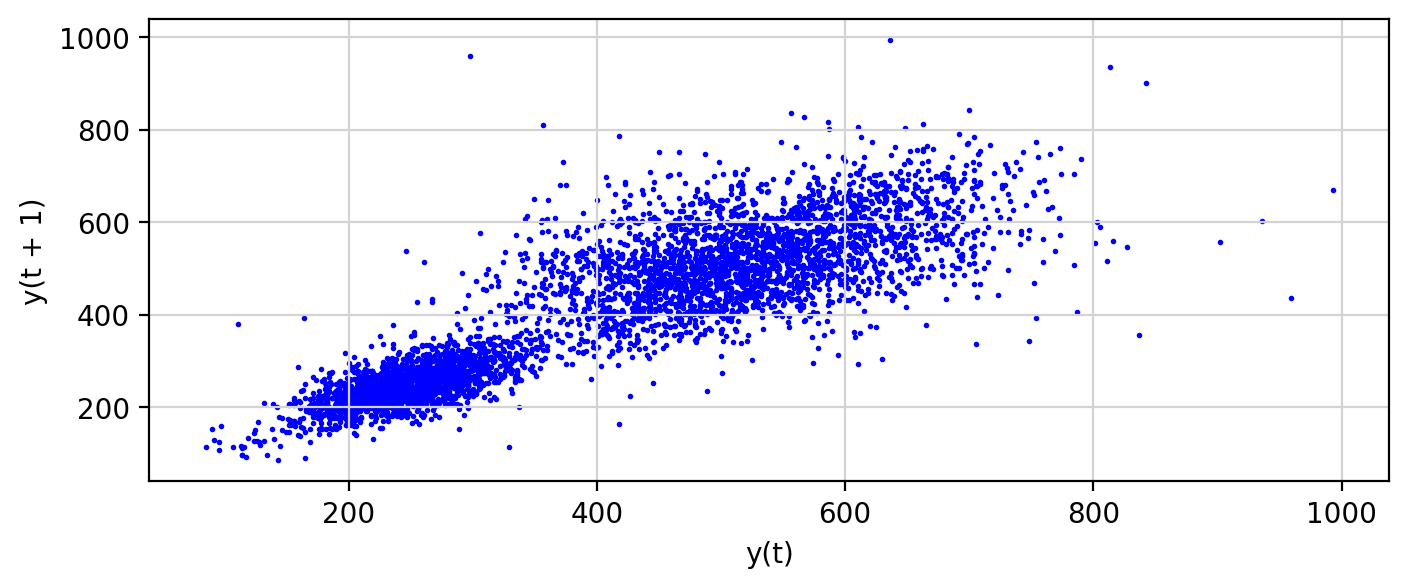

In [63]:
pd.plotting.lag_plot(acc['accidents'], lag = 1, c='b', s=1)

<Axes: xlabel='y(t)', ylabel='y(t + 7)'>

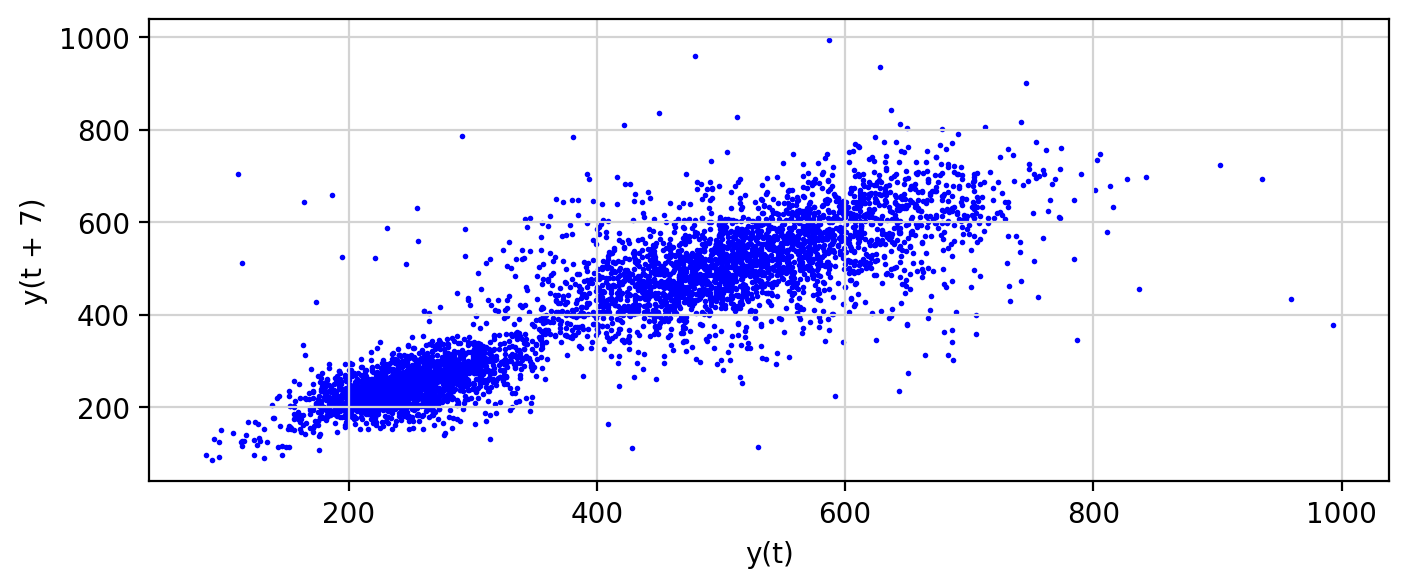

In [64]:
pd.plotting.lag_plot(acc['accidents'], lag = 7, c='b', s=1)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

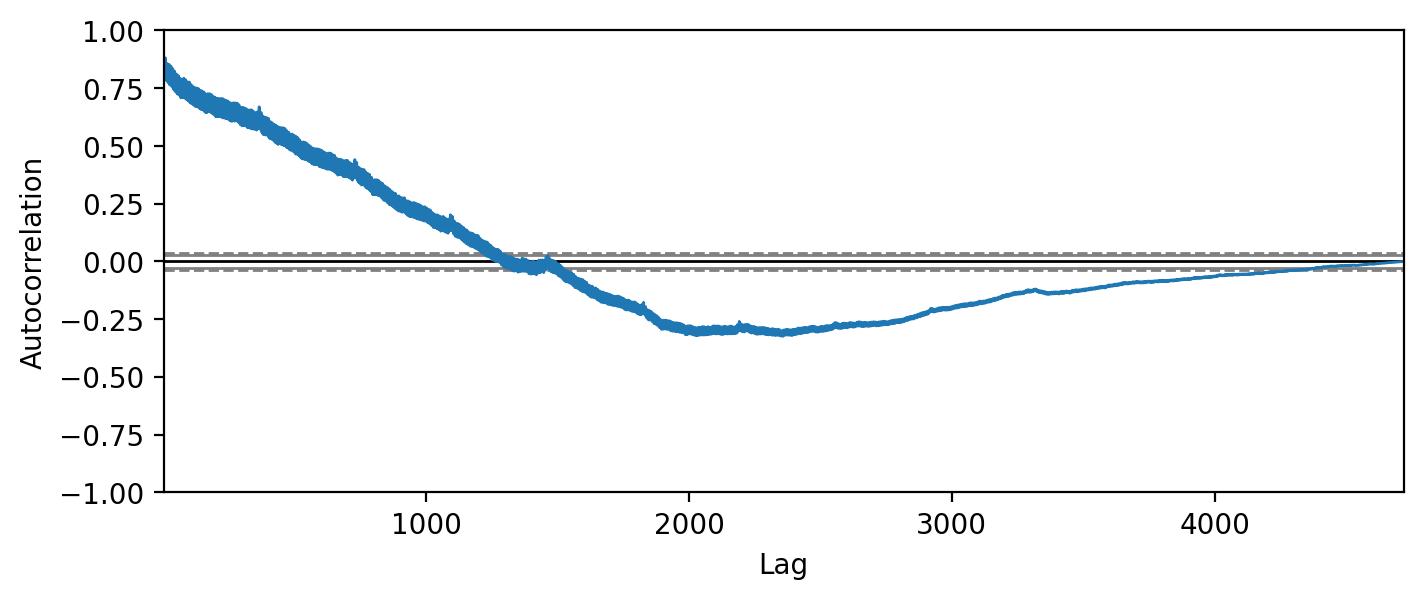

In [65]:
pd.plotting.autocorrelation_plot(acc['accidents'])

(0.0, 90.0)

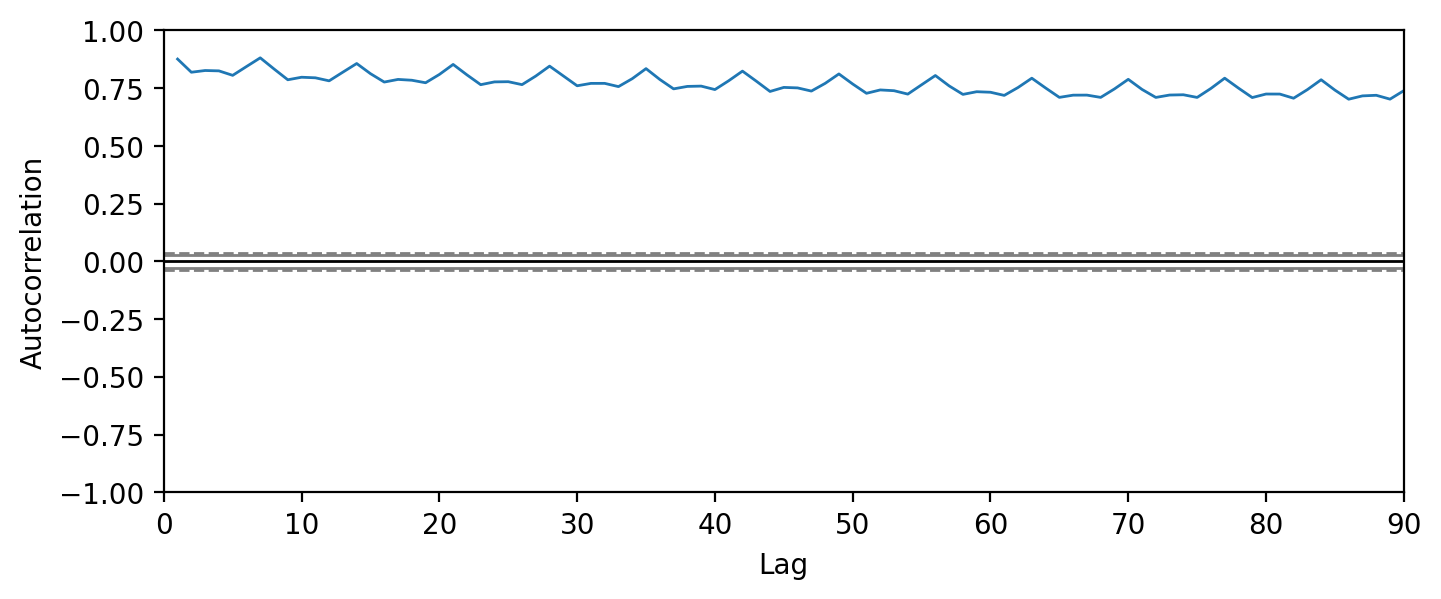

In [66]:
plot = pd.plotting.autocorrelation_plot(acc['accidents'])
plot.set_xlim(0,90)

<Figure size 1000x800 with 0 Axes>

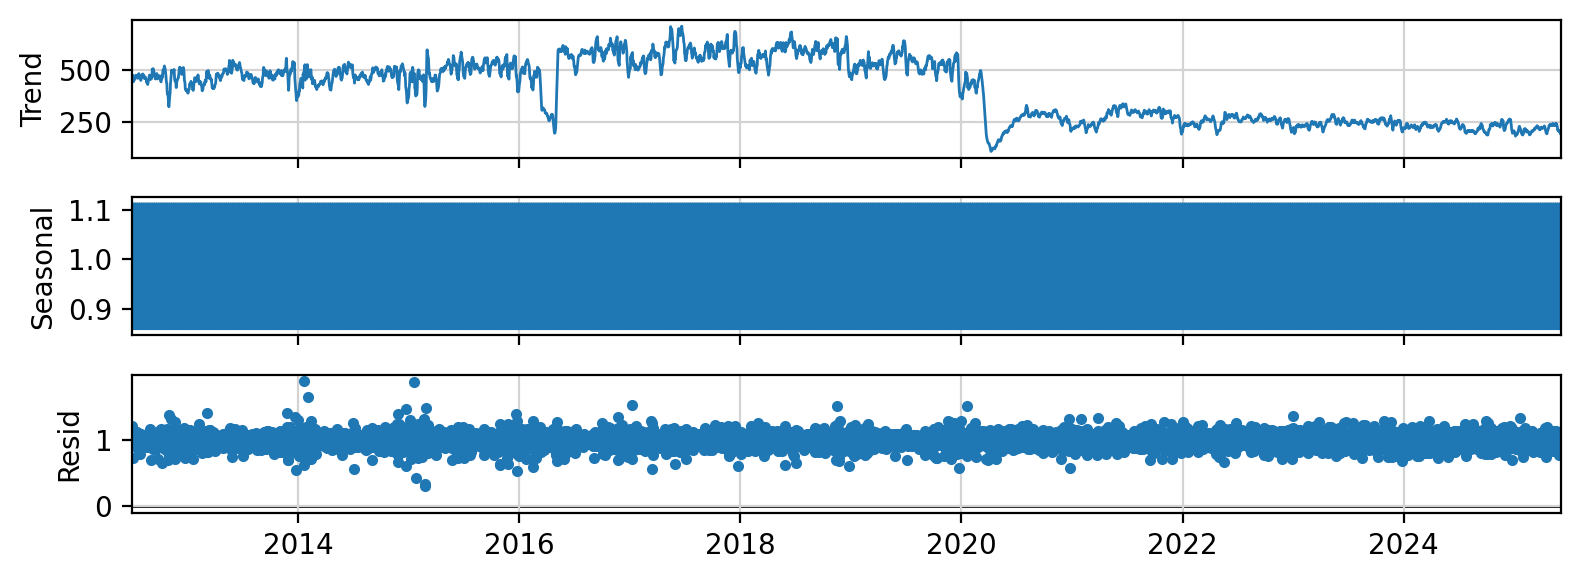

In [67]:
from statsmodels.tsa.seasonal import seasonal_decompose

# We decompose assumming a 12-month periodicity.
# We can also specify a multiplicative instead of an additive model
# The additive model is Y[t] = T[t] + S[t] + e[t]
# The multiplicative model is Y[t] = T[t] * S[t] * e[t]

period = 7 # We have daily observations, and we consider one week
             # as the seasonality period
decomposition = seasonal_decompose(x = acc['accidents'],
                                   model='multiplicative',
                                   period=period,
                                   extrapolate_trend=period
                )

fig = plt.figure(figsize = (10,8))
fig = decomposition.plot(
    observed=False,
    seasonal=True,
    trend=True,
    resid=True,
)

<Axes: xlabel='acc_date'>

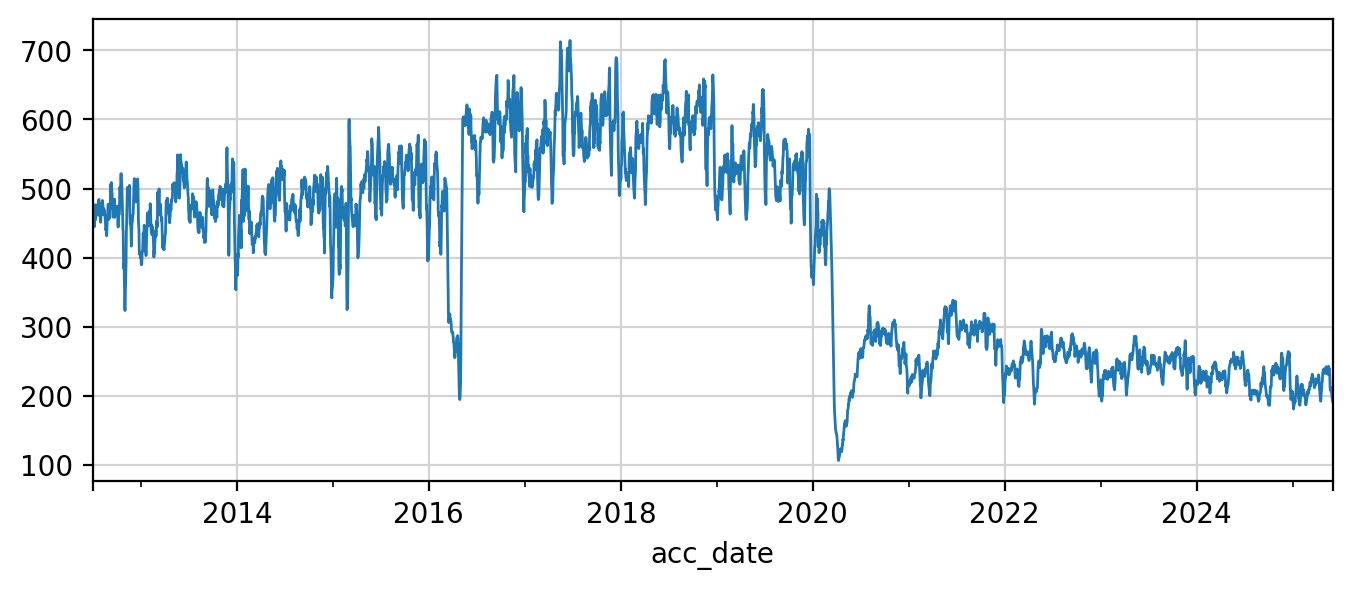

In [68]:
# Plot the trend
decomposition.trend.plot()

<Axes: xlabel='acc_date'>

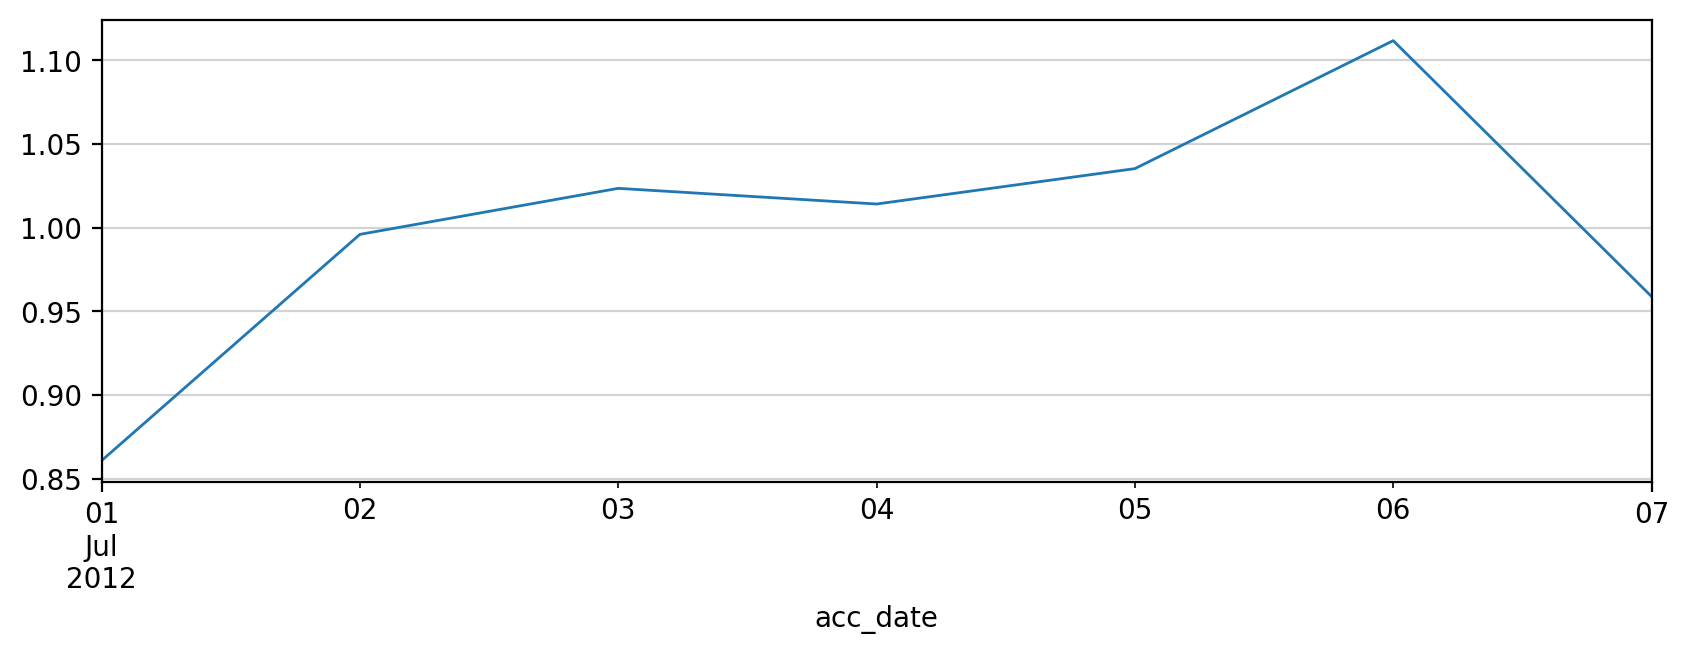

In [69]:
# Plot the seasonal component for the first week of the data
decomposition.seasonal.head(period).plot(figsize=(10,3))

<Axes: xlabel='acc_date'>

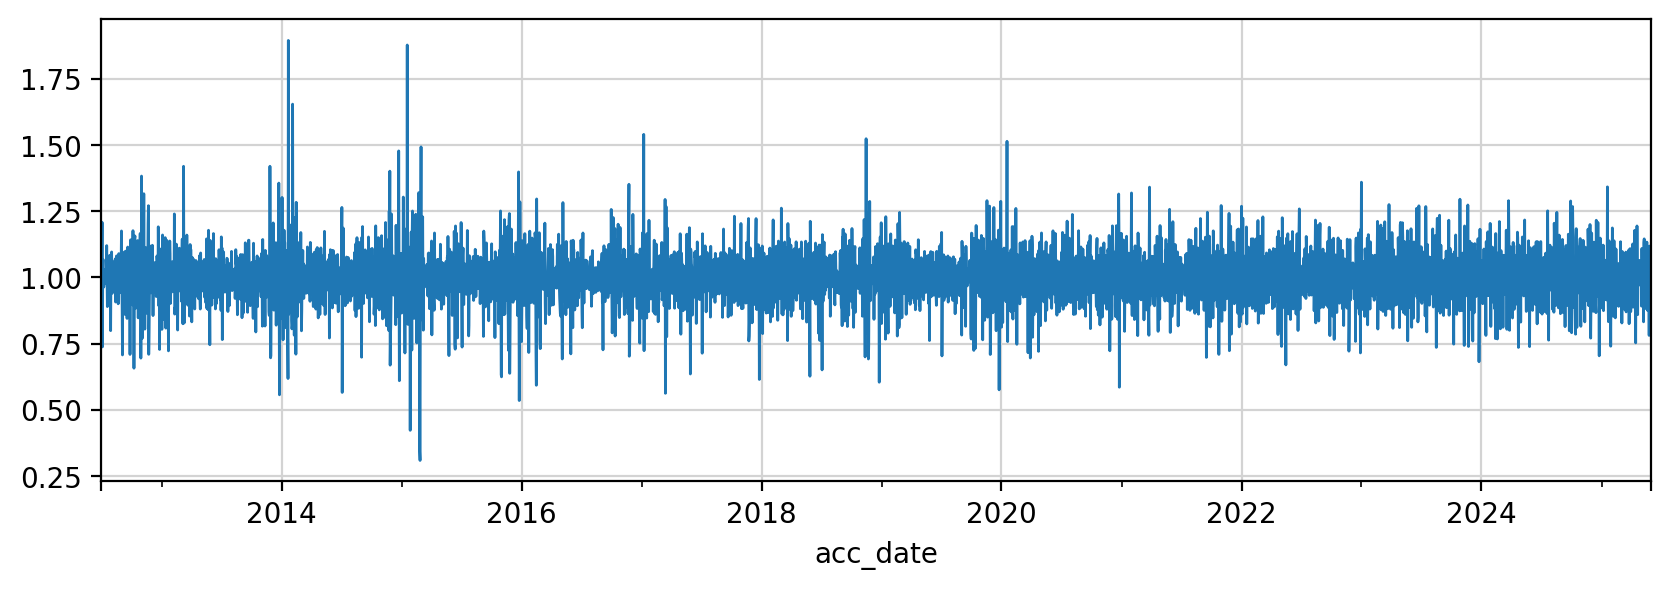

In [70]:
# Plot the residual
decomposition.resid.plot(figsize=(10,3))

In [71]:
# Identify the dates with the highest/lowest
# residual  components
decomposition.resid.sort_values()

,resid
acc_date,
2015-02-26,0.308743
2015-02-25,0.342732
2015-01-27,0.422485
2015-12-25,0.535012
2013-12-25,0.556674
...,...
2018-11-15,1.523924
2017-01-07,1.540366
2014-02-03,1.654600


In [72]:
decomposition.resid.sort_values().head(10)

,resid
acc_date,
2015-02-26,0.308743
2015-02-25,0.342732
2015-01-27,0.422485
2015-12-25,0.535012
2013-12-25,0.556674
2017-03-14,0.562340
2014-07-04,0.565605
2019-12-25,0.575433
2020-12-25,0.585380


In [73]:
decomposition.resid.sort_values().tail(10)

,resid
acc_date,
2013-03-08,1.419822
2013-11-26,1.419910
2014-12-23,1.477897
2015-03-01,1.493114
2020-01-18,1.514254
2018-11-15,1.523924
2017-01-07,1.540366
2014-02-03,1.654600
2015-01-18,1.877975


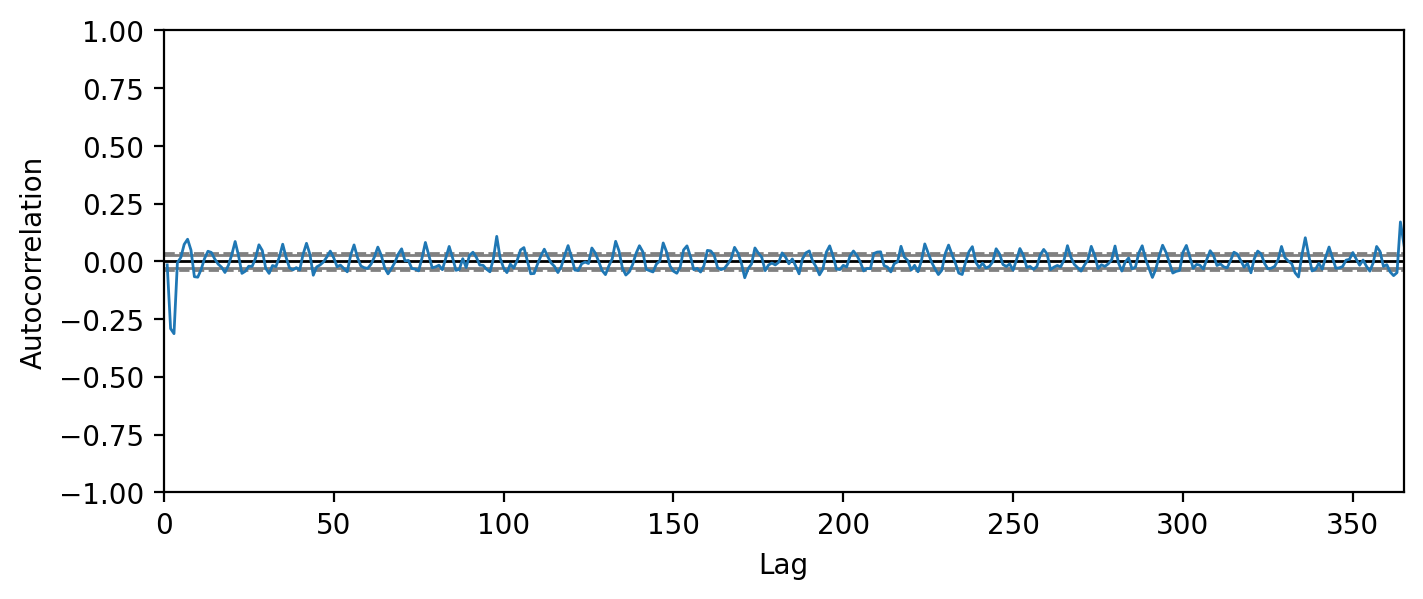

In [74]:
# Examine the autocorrelation structure of the residuals
ax = pd.plotting.autocorrelation_plot(decomposition.resid, linewidth=1)
ax.set_xlim( [0,365] )
pass

## Advanced: Time Series Window operations: Rolling / Expanding / EW

One question that comes up when we have a periodic time series is: "How can I figure out the overall trend?". In the examples above, we relied on a "black box" where we simply asked for the time series to be decomposed into a trend, seasonal, and residual component. Now, let's dig a bit deeper on how we can extract trend components that are unaffected by seasonality.

For that, we often rely on "window" functions, that operate over a set of continuous time series points. For example, if we have a time series that has a 12-month seasonality, we can take the 12-month average, which will not exhibit seasonality, but will capture the trend.

These windows functions are common time series operations. Pandas provides support for various types of windows. Here are a few that are commonly used:
* [Rolling window](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html): We compute the function over a time period equal to a window
* [Expanding](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.expanding.html): We compute the function over a period of 1, 2, 3,... instances.
* [Exponential weighting](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.ewm.html): We keep a window of a fixed size but we weight less and less (exponentially) the old data points.

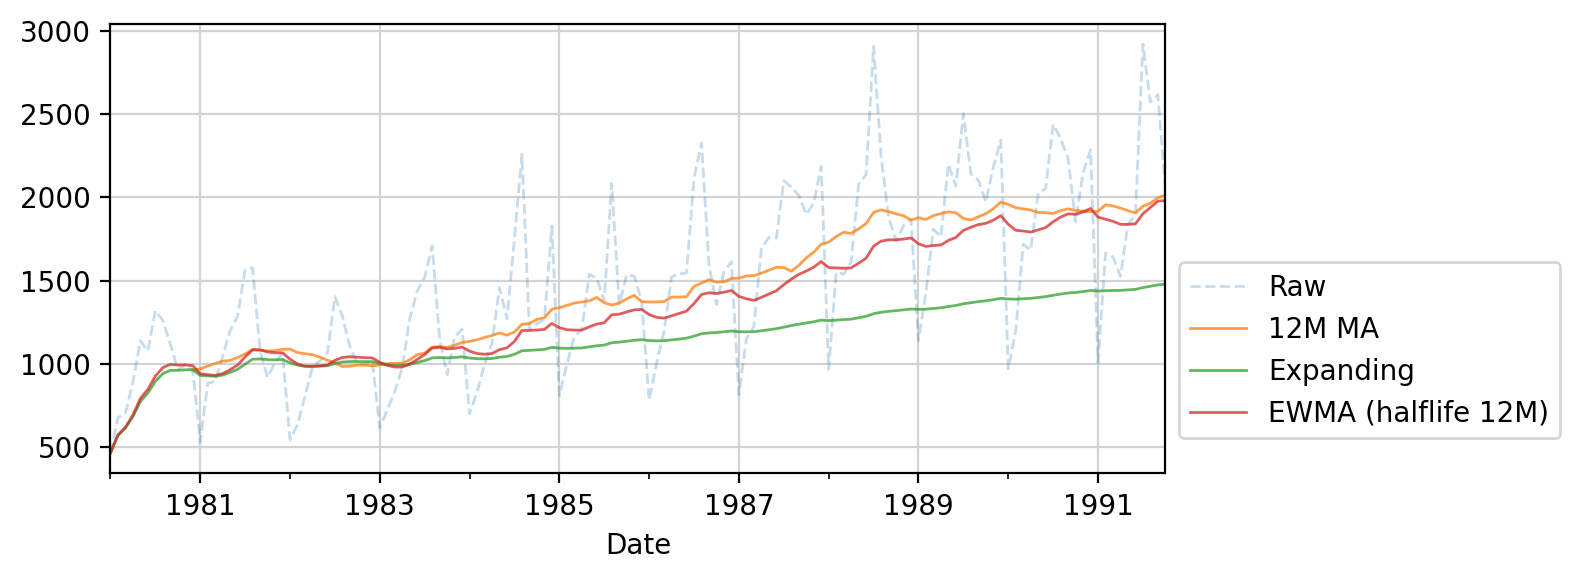

In [75]:
# Use different linestyle, and use high alpha to make the series less visually prominent
df['Sales'].plot(label='Raw', linestyle ="--", alpha=0.25)

# Plot the 12-month moving average
df['Sales'].rolling(12).mean().plot(label='12M MA', alpha=0.75)

# Plot the expanding mean. This is the mean of the series from the beginning till that point in time
df['Sales'].expanding().mean().plot(label='Expanding', alpha=0.75)

# Plot the exponentially weighted moving average. This moving average weighs more heavily the newer
# data points and weighs less the old ones.
df['Sales'].ewm(halflife=12).mean().plot(label='EWMA (halflife 12M)', alpha=0.75)

# places the legend to the right side (1) and middle of the y-axis (0.5)
plt.legend(bbox_to_anchor=(1, .5))
plt.tight_layout()